In [1]:
import warnings

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from imblearn.over_sampling import SMOTE

import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import pickle
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble._hist_gradient_boosting import gradient_boosting
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler, MaxAbsScaler, \
    MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, BaggingClassifier, StackingClassifier, \
    AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import LSTM, GRU
from joblib import dump, load
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import optuna


C:\Users\lemon\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('transaction_dataset.csv', index_col=0)

In [4]:
print(df.shape)

(9841, 50)


In [5]:
print(df.head())

   Index                                     Address  FLAG  \
0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8     0   
1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed     0   
2      3  0x0002bda54cb772d040f779e88eb453cac0daa244     0   
3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e     0   
4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89     0   

   Avg min between sent tnx  Avg min between received tnx  \
0                    844.26                       1093.71   
1                  12709.07                       2958.44   
2                 246194.54                       2434.02   
3                  10219.60                      15785.09   
4                     36.61                      10707.77   

   Time Diff between first and last (Mins)  Sent tnx  Received Tnx  \
0                                704785.63       721            89   
1                               1218216.73        94             8   
2                                516729.30        

In [6]:
df = df.iloc[:,2:]

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841

In [8]:
categories = df.select_dtypes('O').columns.astype('category')

In [9]:
for i in df[categories].columns:
    print(f'The categorical column --{i}-- has --{len(df[i].value_counts())}-- unique values')

The categorical column -- ERC20 most sent token type-- has --305-- unique values
The categorical column -- ERC20_most_rec_token_type-- has --467-- unique values


In [10]:
numericals = df.select_dtypes(include=['float','int']).columns

In [11]:
df[numericals].describe()

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,5086.878721,8004.851184,2.183333e+05,43.845153,523.152481,100.711721,4.800090,314.617297,44.755731,0.000003,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,21486.549974,23081.714801,3.229379e+05,325.929139,13008.821539,2885.002236,138.609682,6629.212643,239.080215,0.000225,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,3.169300e+02,0.001000,1.000000,0.426905,0.000000,0.164577,0.086184,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,17.340000,509.770000,4.663703e+04,0.095856,6.000000,1.729730,0.049126,4.999380,1.606000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,565.470000,5480.390000,3.040710e+05,2.000000,67.067040,22.000000,0.998800,61.520653,21.999380,0.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,430287.670000,482175.490000,1.954861e+06,10000.000000,800000.000000,283618.831600,12000.000000,520000.000000,12000.000000,0.020000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [12]:
df[numericals].var()

Avg min between sent tnx                   4.616718e+08
Avg min between received tnx               5.327656e+08
Time Diff between first and last (Mins)    1.042889e+11
min value received                         1.062298e+05
max value received                         1.692294e+08
avg val received                           8.323238e+06
min val sent                               1.921264e+04
max val sent                               4.394646e+07
avg val sent                               5.715935e+04
min value sent to contract                 5.080371e-08
max val sent to contract                   2.660652e-07
avg value sent to contract                 1.046096e-07
total Ether sent                           1.283952e+11
total ether received                       1.326451e+11
total ether sent contracts                 2.660625e-07
total ether balance                        5.877009e+10
 Total ERC20 tnxs                          2.002821e+05
 ERC20 total Ether received                1.110

In [13]:
print(df['FLAG'].value_counts())

0    7662
1    2179
Name: FLAG, dtype: int64


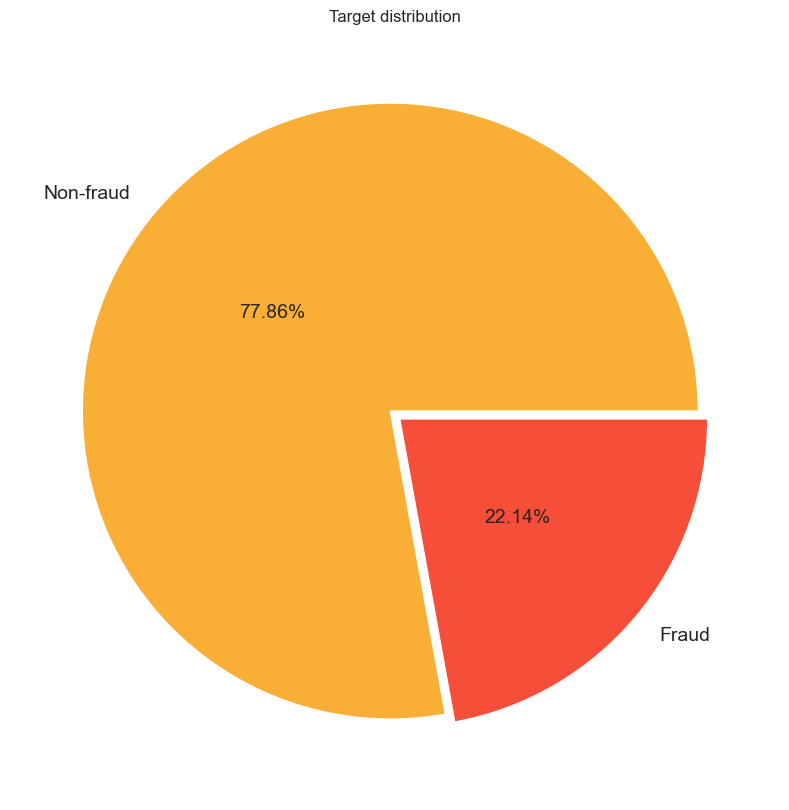

In [14]:
pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

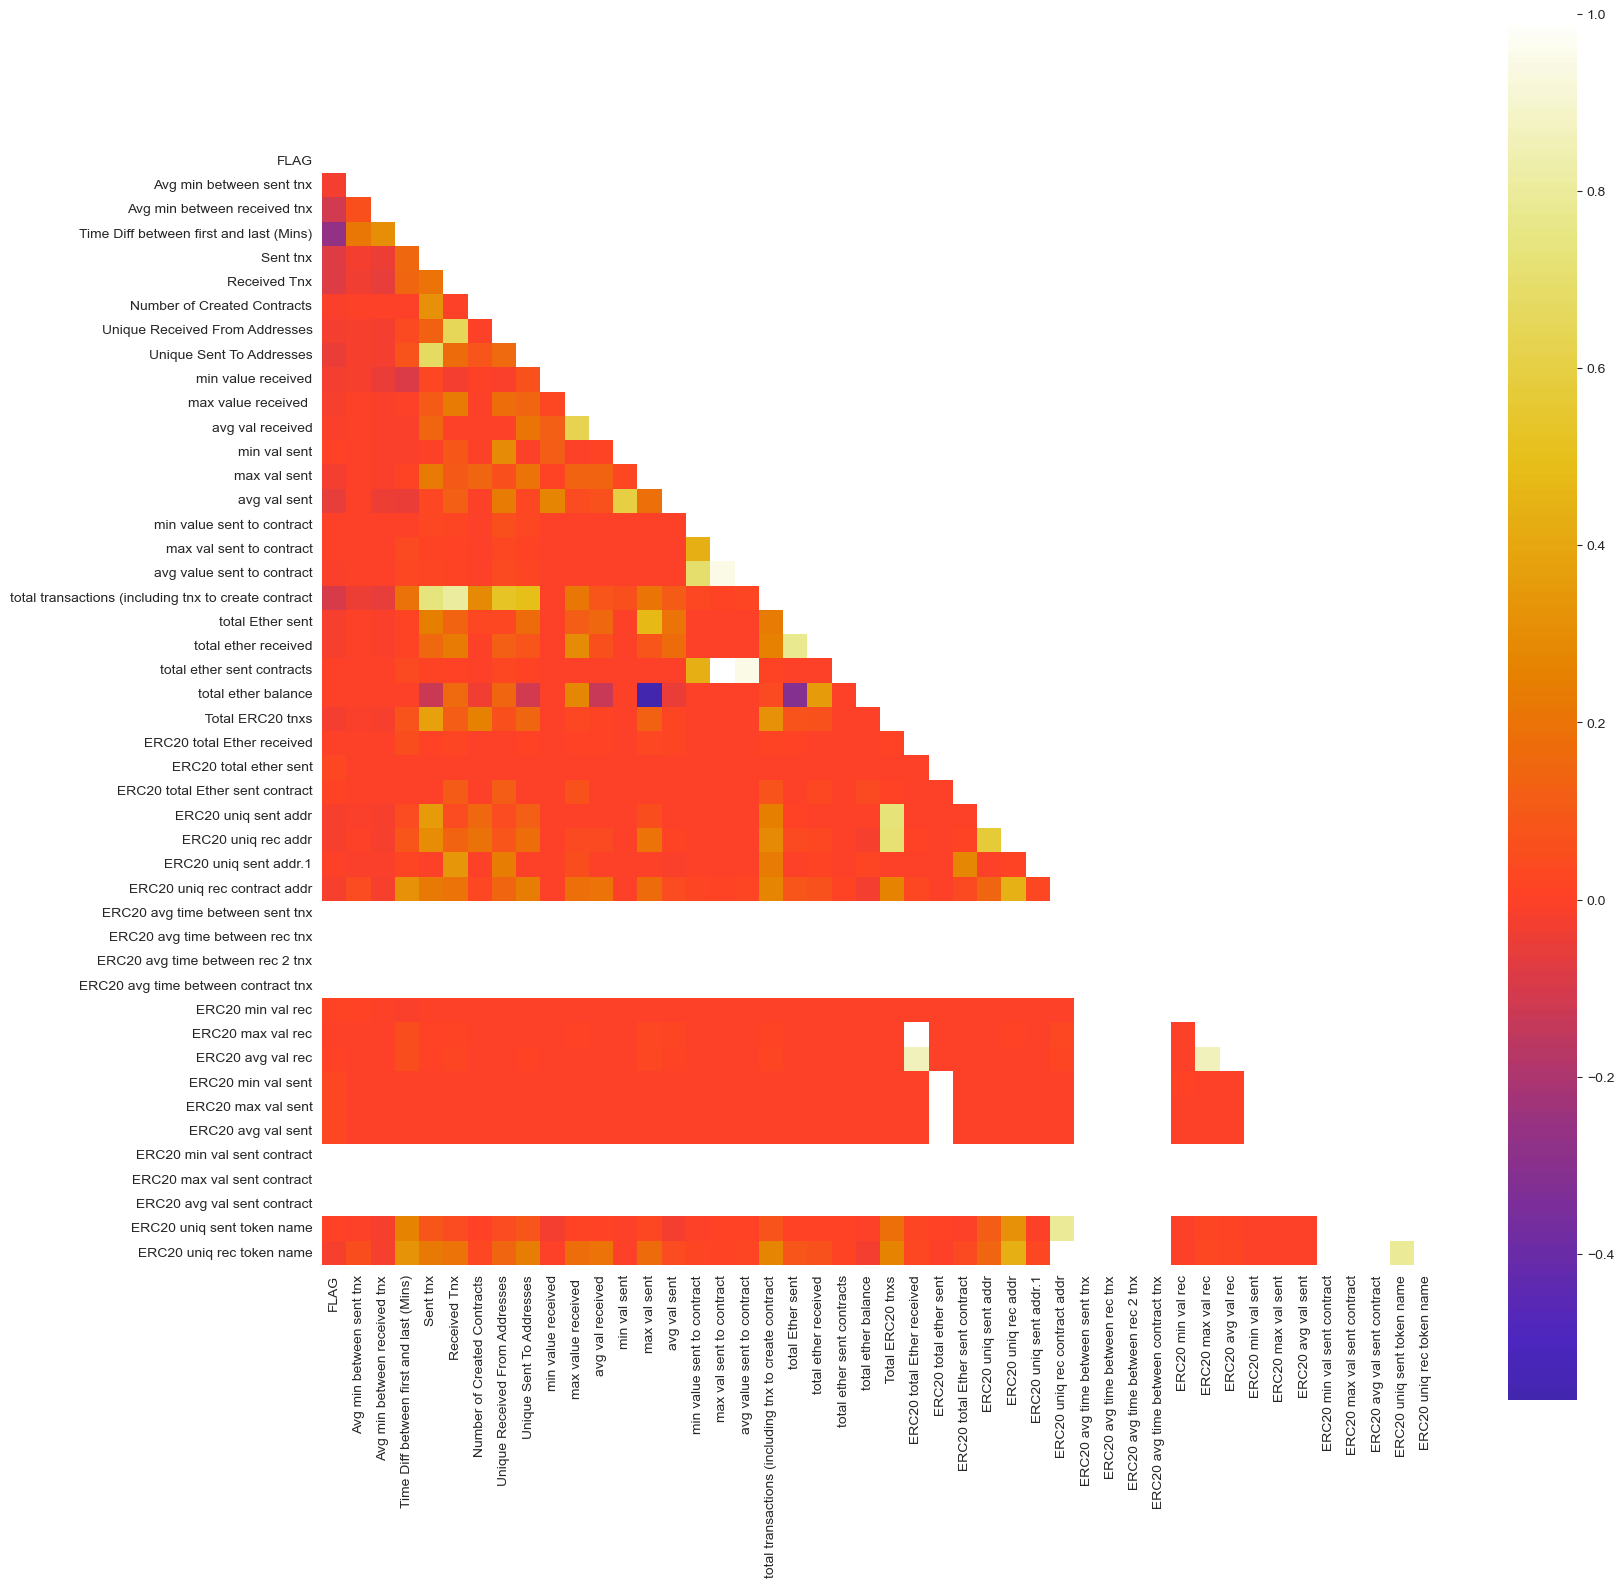

In [15]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,18))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)
plt.show()

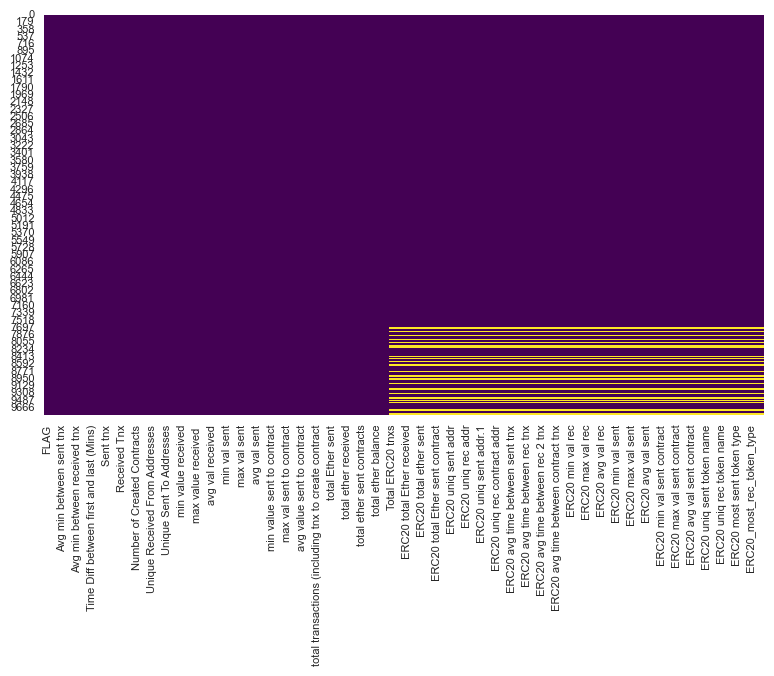

In [16]:
plt.figure(figsize=(12, 10))  
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')  
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.3)
plt.xticks(rotation=90, ha='right', fontsize=8)  

plt.yticks(rotation=0, fontsize=8)   
plt.show()

In [17]:
df.drop(df[categories], axis=1, inplace=True)

In [18]:
df.fillna(df.median(), inplace=True)

(9841, 46)


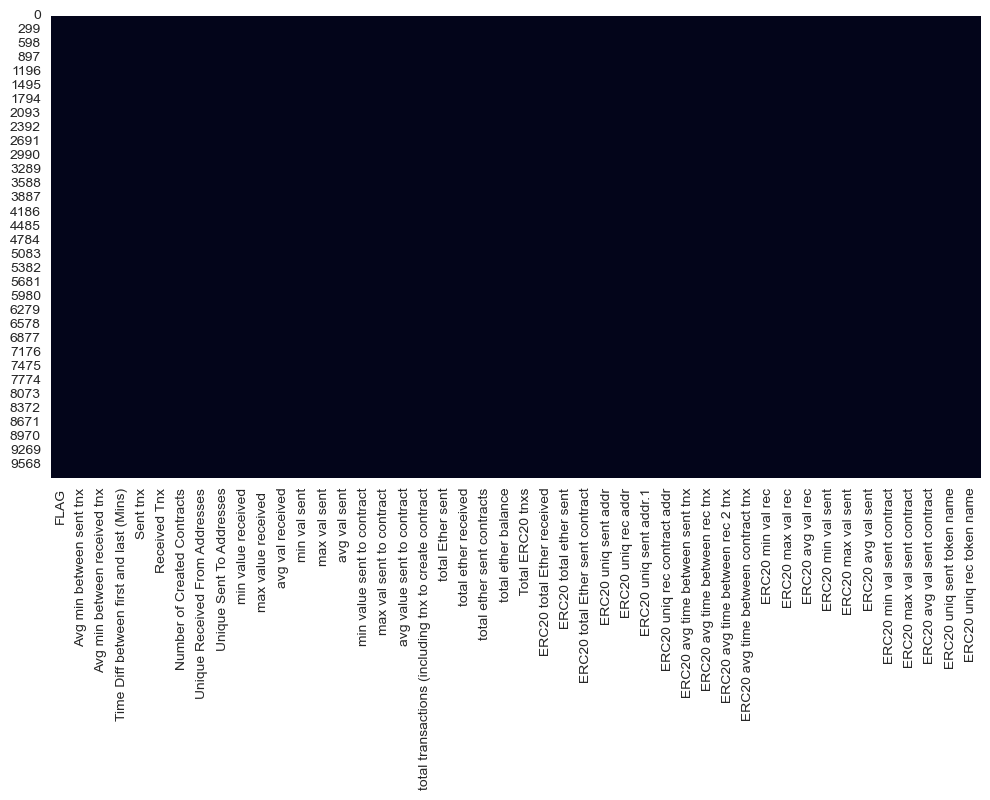

In [19]:
print(df.shape)
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [20]:
no_var = df.var() == 0
print(df.var()[no_var])

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64


In [21]:
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

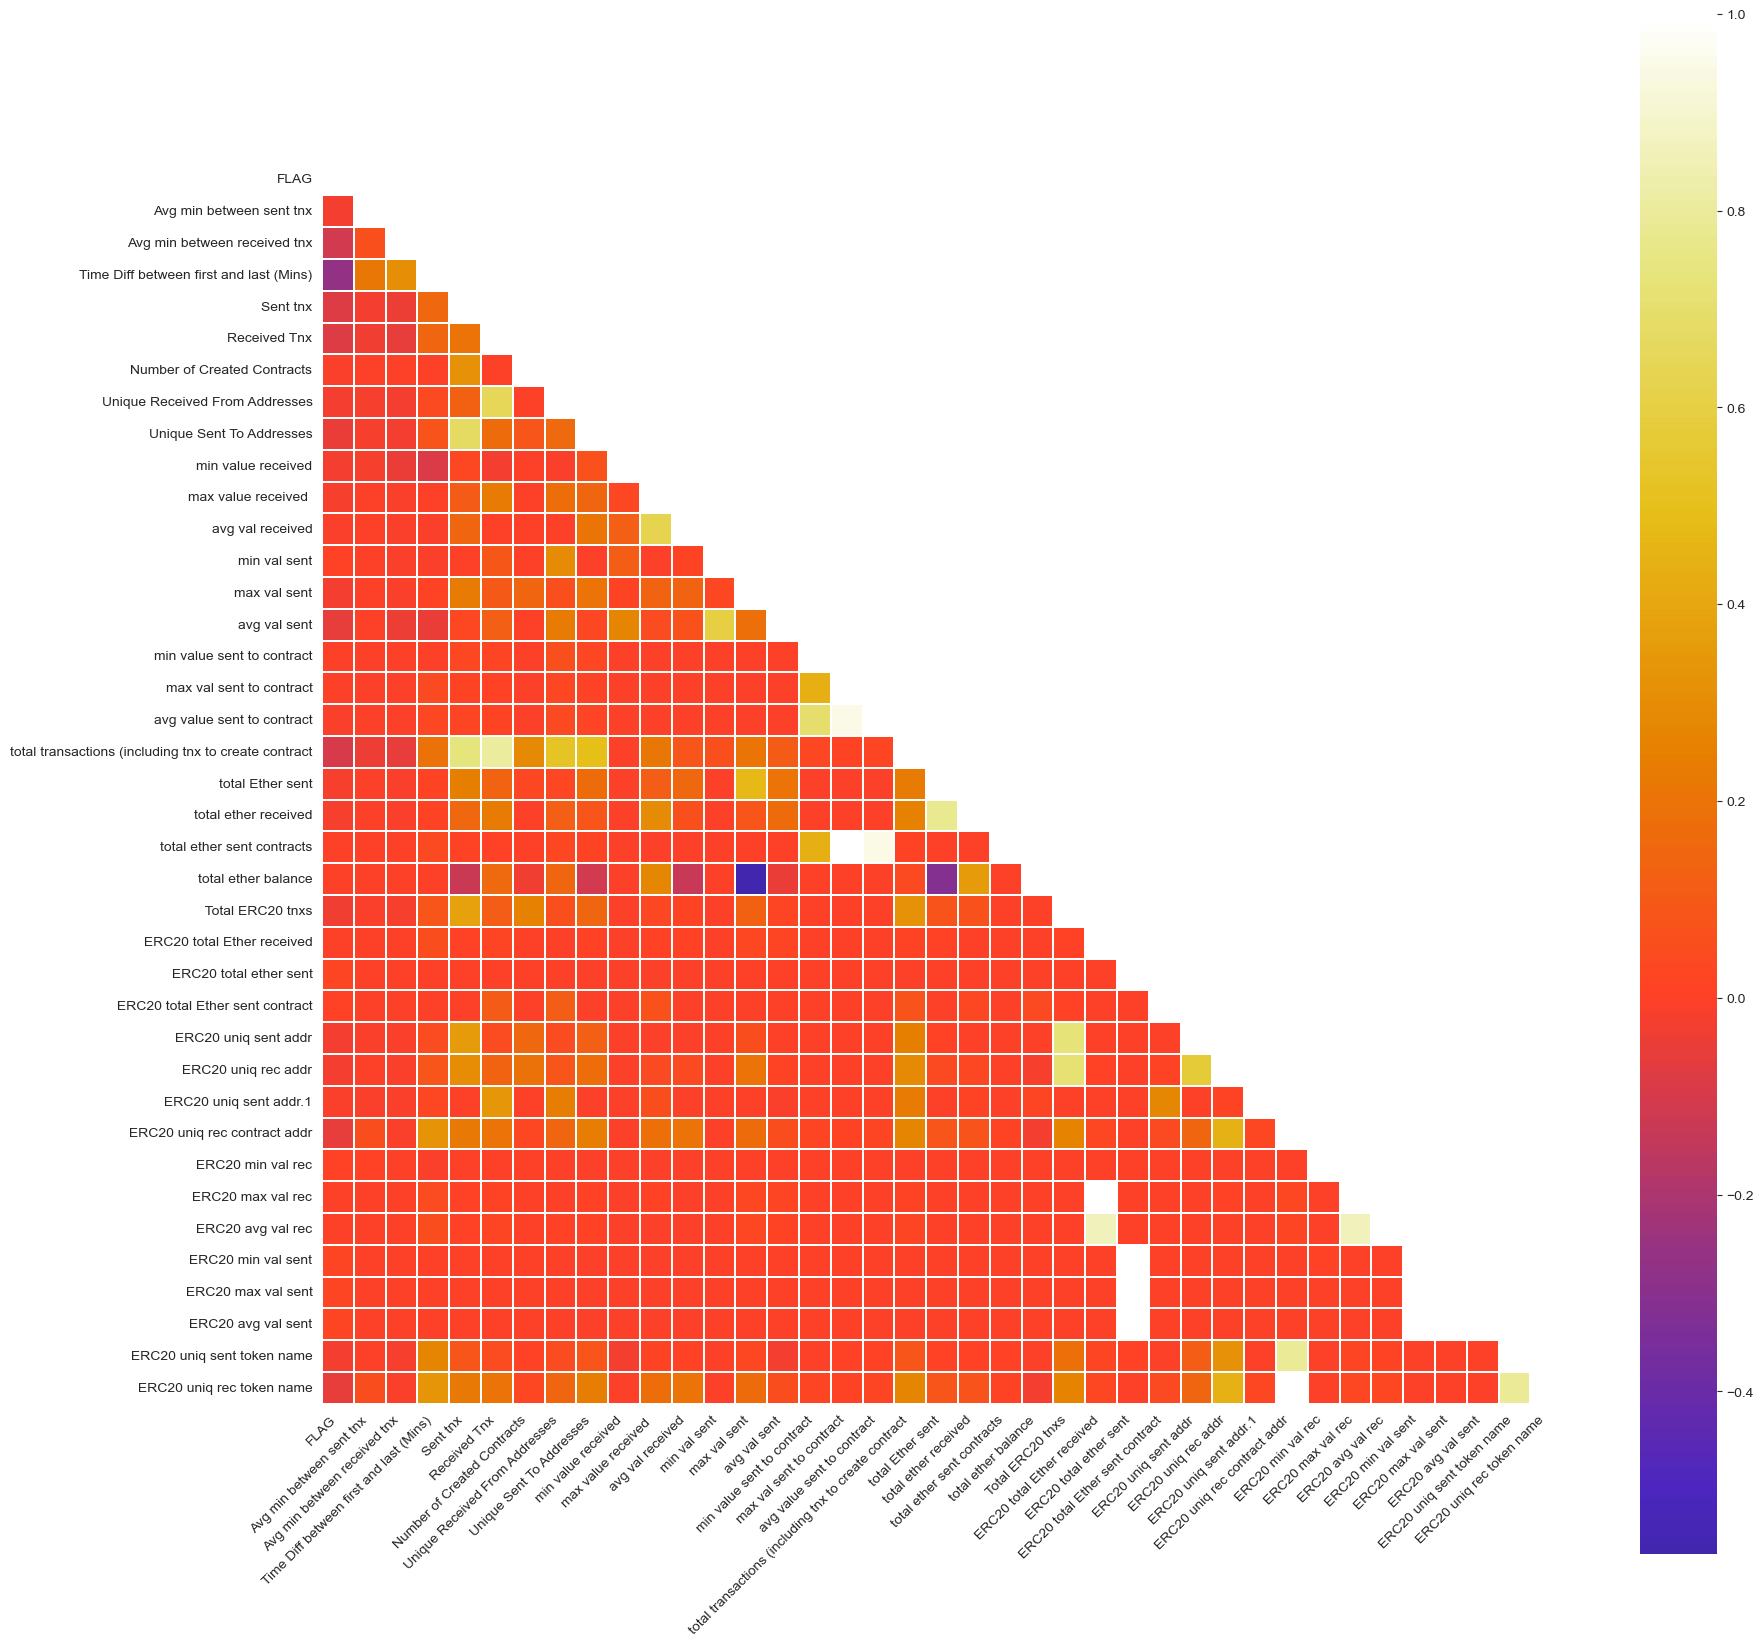

In [22]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(20, 20))  # 调整图形尺寸
    sns.heatmap(corr, mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True, ax=ax)
    plt.xticks(rotation=45, ha='right', fontsize=10)  # 旋转特征名称并调整字体大小
    plt.yticks(rotation=0, fontsize=10)  # 调整字体大小
    plt.show()

In [23]:
drop = [ 'avg value sent to contract', ' ERC20 min val sent',' ERC20 max val sent',
        ' ERC20 avg val sent','max val sent to contract','total ether sent contracts'
         ,'Time Diff between first and last (Mins)', 'total ether balance', ' ERC20 max val rec'
         ,' ERC20 uniq rec token name',' ERC20 avg val rec','total transactions (including tnx to create contract'
         ,' ERC20 uniq sent token name',' Total ERC20 tnxs']
df.drop(drop, axis=1, inplace=True)

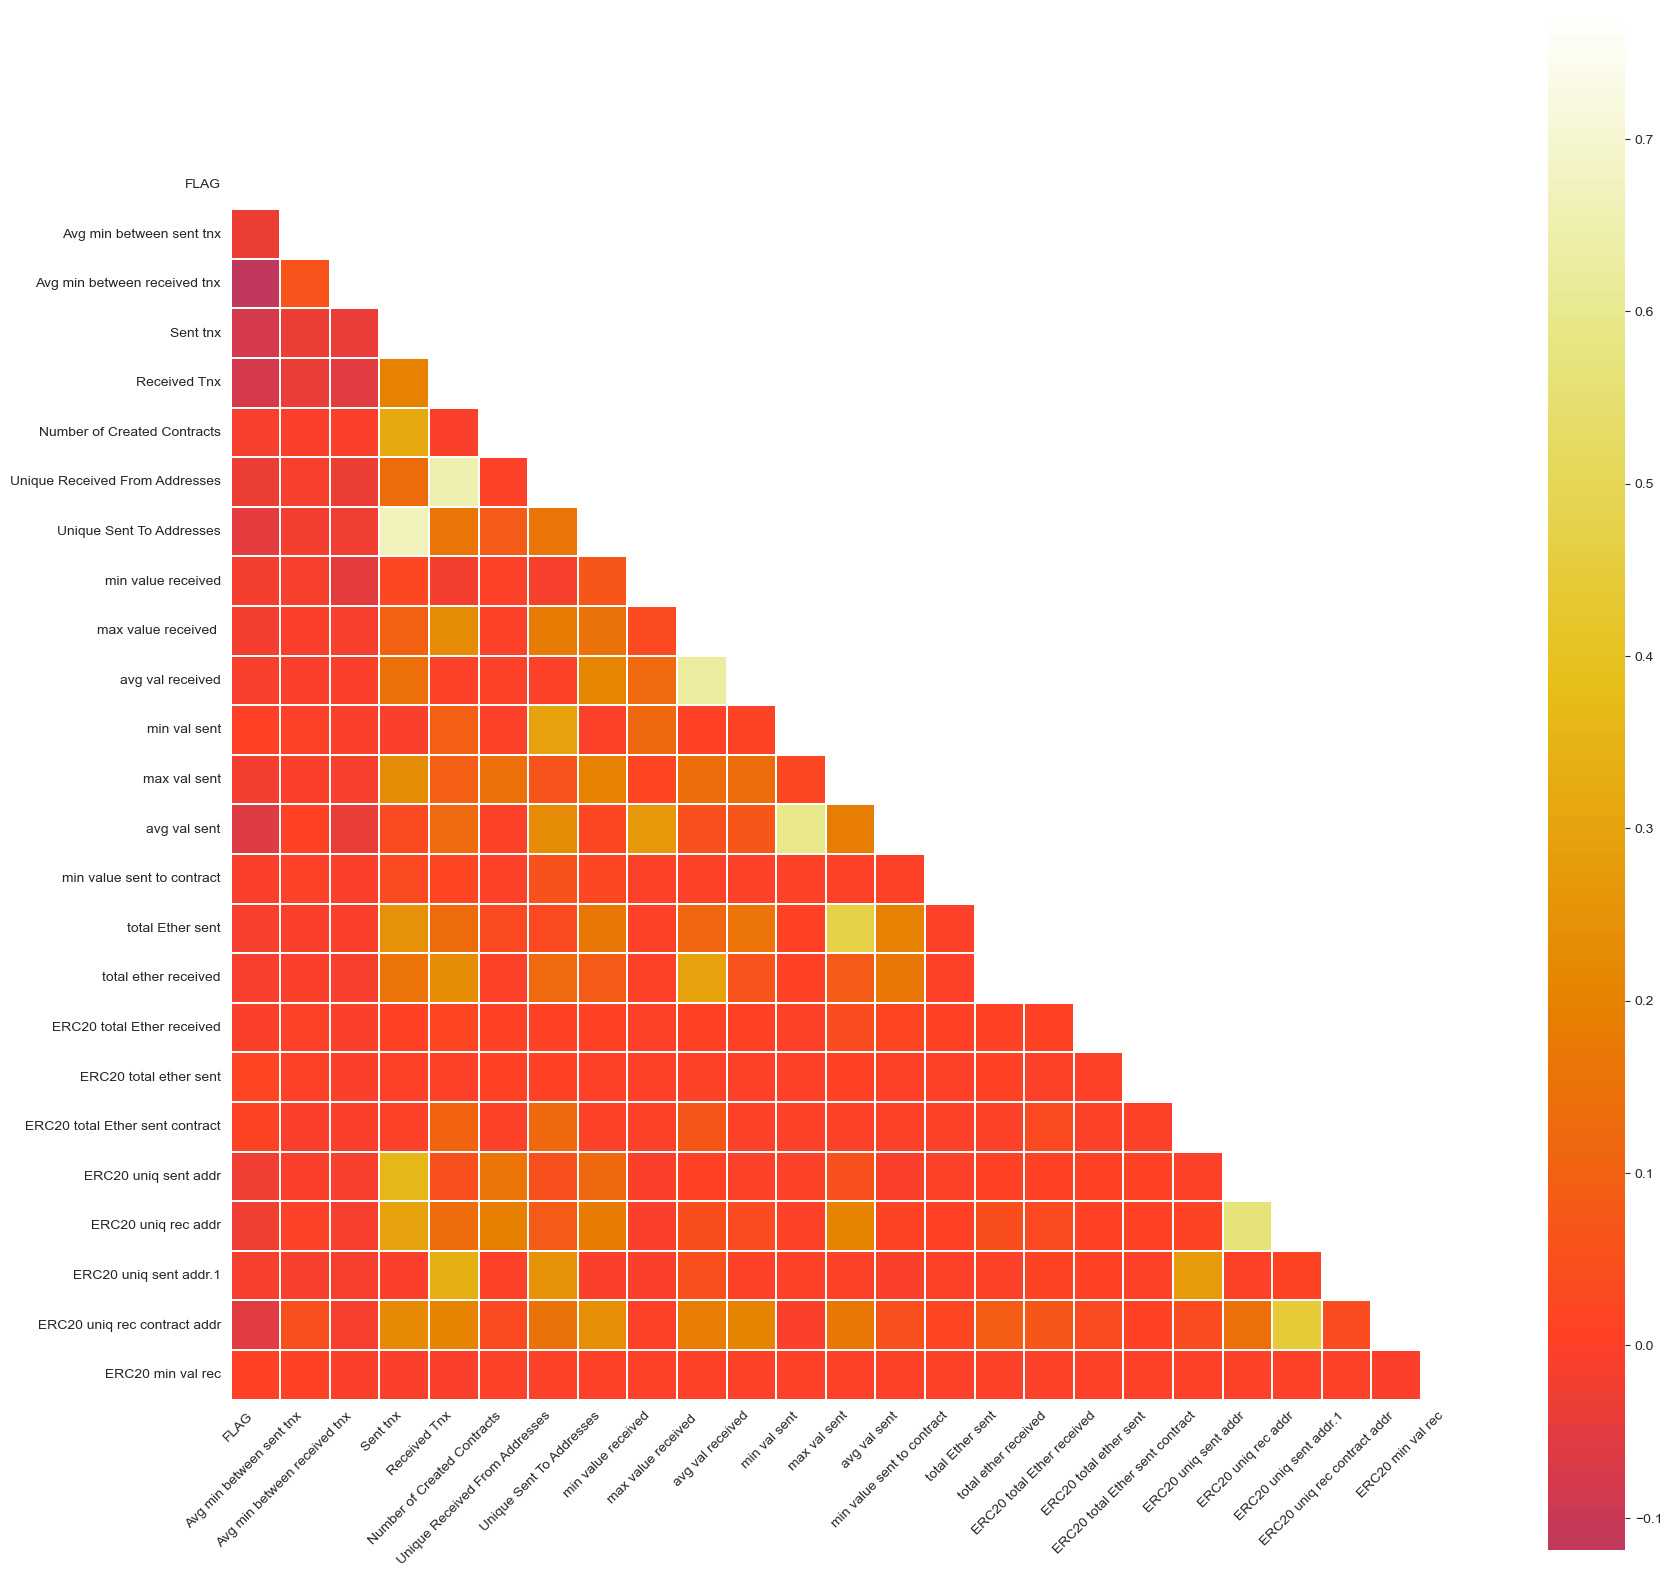

In [24]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(20, 20))  # 调整图形尺寸
    sns.heatmap(corr, mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True, ax=ax)
    plt.xticks(rotation=45, ha='right', fontsize=10)  # 旋转特征名称并调整字体大小
    plt.yticks(rotation=0, fontsize=10)  # 调整字体大小
    plt.show()

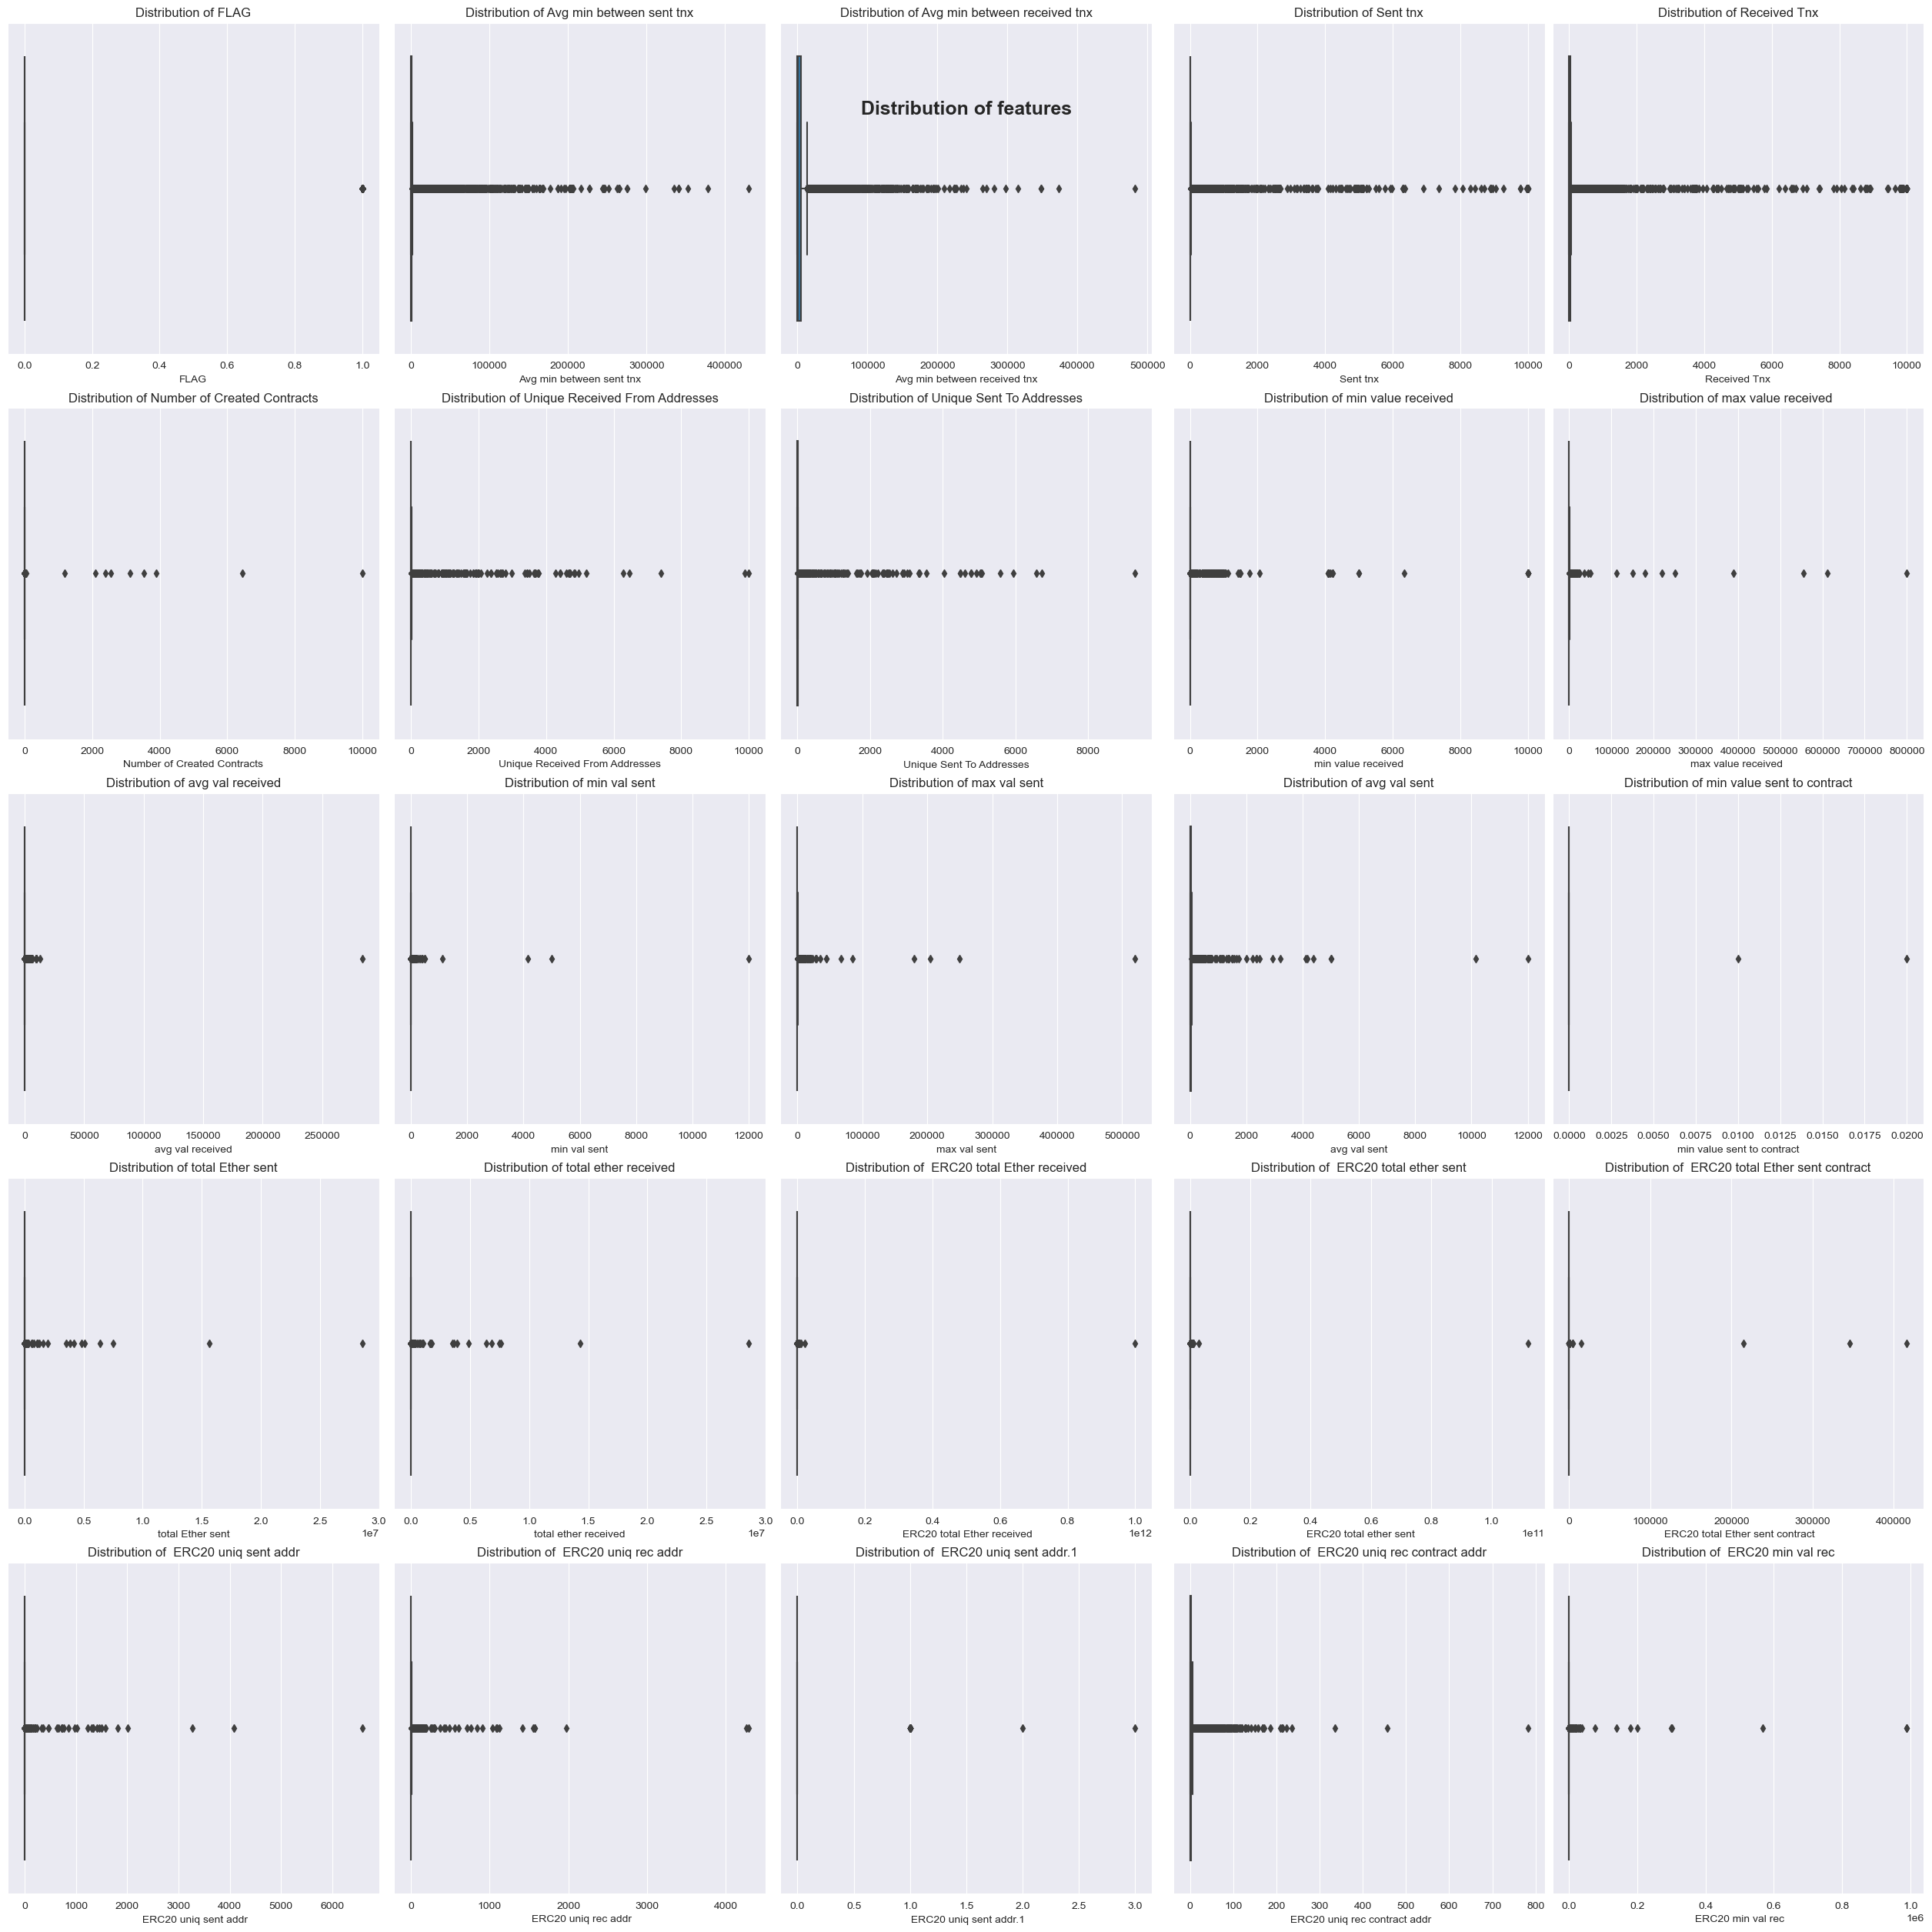

In [25]:
columns = df.columns
num_cols = len(columns)
num_rows = (num_cols - 1) // 5 + 1
fig, axes = plt.subplots(num_rows, 5, figsize=(25, 25), constrained_layout=True)
plt.subplots_adjust(wspace=0.7, hspace=0.8)
plt.suptitle("Distribution of features", y=0.95, size=18, weight='bold')

for i, ax in enumerate(axes.flat):
    if i < num_cols:
        sns.boxplot(ax=ax, data=df, x=columns[i])
        ax.set_title(f'Distribution of {columns[i]}')
    else:
        ax.set_visible(False)

plt.show()

In [26]:
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min value sent to contract has the following distribution: 
0.00    9839
0.02       1
0.01       1
Name: min value sent to contract, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
0.0    9813
1.0      26
2.0       1
3.0       1
Name:  ERC20 uniq sent addr.1, dtype: int64


In [27]:
drops = [' ERC20 uniq sent addr.1','min value sent to contract']
df.drop(drops, axis=1, inplace=True)
print(df.shape)
df.head()

(9841, 23)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,avg val sent,total Ether sent,total ether received,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq rec contract addr,ERC20 min val rec
0,0,844.26,1093.71,721,89,0,40,118,0.000000,45.806785,...,1.200681,865.691093,586.466675,3.558854e+07,3.560317e+07,0.0,30.0,54.0,58.0,0.0
1,0,12709.07,2958.44,94,8,0,5,14,0.000000,2.613269,...,0.032844,3.087297,3.085478,4.034283e+02,2.260809e+00,0.0,1.0,5.0,7.0,0.0
2,0,246194.54,2434.02,2,10,0,10,2,0.113119,1.165453,...,1.794308,3.588616,3.589057,5.215121e+02,0.000000e+00,0.0,0.0,7.0,8.0,0.0
3,0,10219.60,15785.09,25,9,0,7,13,0.000000,500.000000,...,70.001834,1750.045862,895.399559,1.711105e+04,1.141223e+04,0.0,2.0,11.0,11.0,0.0
4,0,36.61,10707.77,4598,20,1,7,19,0.000000,12.802411,...,0.022688,104.318883,53.421896,1.628297e+05,1.235399e+05,0.0,4.0,23.0,27.0,0.0


In [28]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9841, 22) (9841,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 22) (7872,)
(1969, 22) (1969,)


In [30]:
norm =QuantileTransformer()
norm_train_f = norm.fit_transform(X_train)

In [31]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)

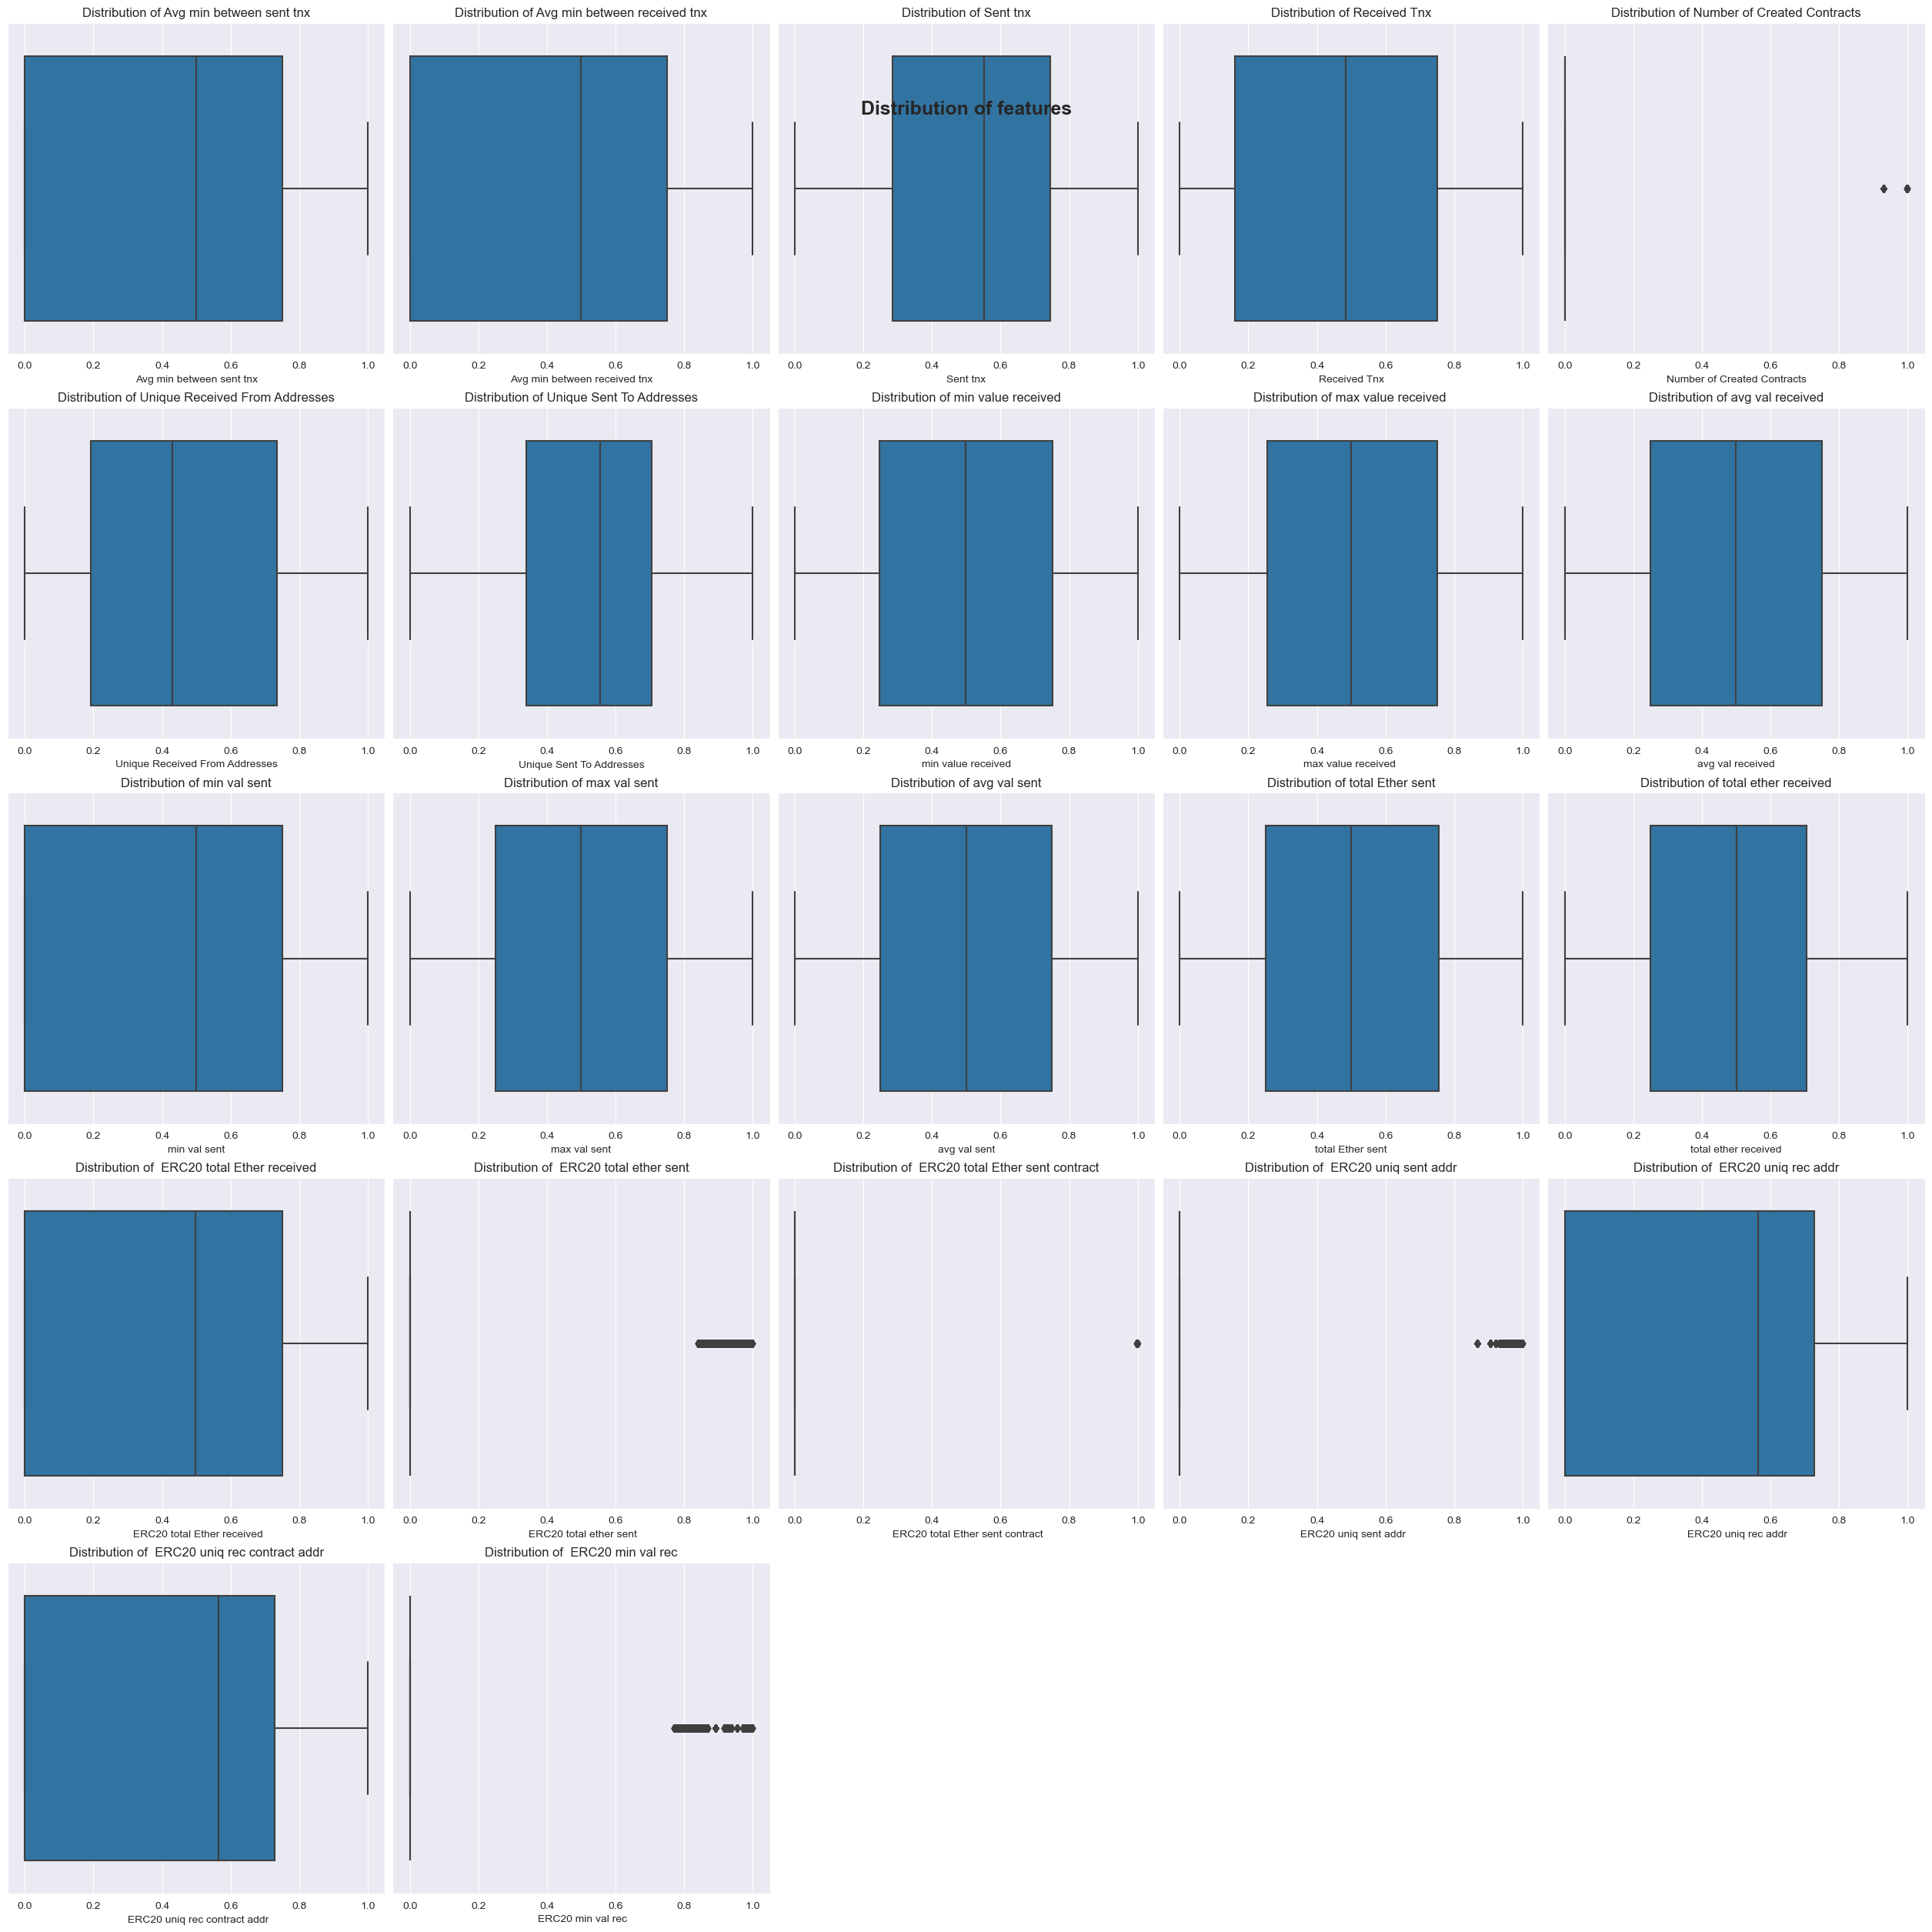

In [32]:
columns = norm_df.columns
num_cols = len(columns)
num_rows = (num_cols - 1) // 5 + 1
fig, axes = plt.subplots(num_rows, 5, figsize=(25, 25), constrained_layout=True)
plt.subplots_adjust(wspace=0.7, hspace=0.8)
plt.suptitle("Distribution of features", y=0.95, size=18, weight='bold')

for i, ax in enumerate(axes.flat):
    if i < num_cols:
        sns.boxplot(ax=ax, data=norm_df, x=columns[i])
        ax.set_title(f'Distribution of {columns[i]}')
    else:
        ax.set_visible(False)
plt.show()

In [33]:
oversample = SMOTE()

In [34]:
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

Shape of the training before SMOTE: ((7872, 22), (7872,))


In [35]:
x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training after SMOTE: ((12230, 22), (12230,))


In [36]:
non_fraud = 0
fraud = 0

for i in y_train:
    if i == 0:
        non_fraud +=1
    else:
        fraud +=1

In [37]:
no = 0
yes = 1

for j in y_tr_resample:
    if j == 0:
        no +=1
    else:
        yes +=1

In [38]:
print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')

BEFORE OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 1757


In [39]:
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

AFTER OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 6116


In [40]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
print(X_train_scaled.shape)

(7872, 22)


In [42]:
print(X_test_scaled.shape)

(1969, 22)


In [43]:
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

Training time for LR: 0.08 seconds
Training time for LR: 0.00 seconds
Confusion Matrix:
[[1455   92]
 [  29  393]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1547
           1       0.81      0.93      0.87       422

    accuracy                           0.94      1969
   macro avg       0.90      0.94      0.91      1969
weighted avg       0.94      0.94      0.94      1969


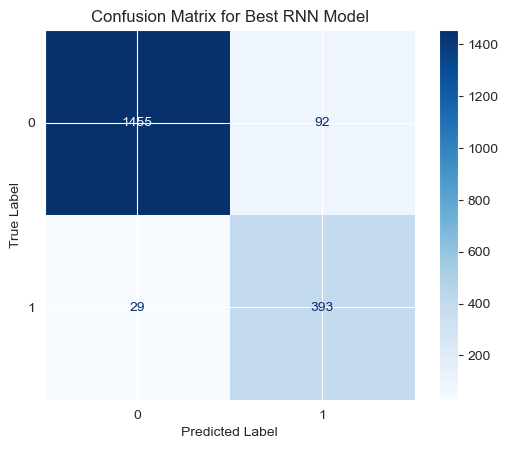

In [55]:
start_time = time.time()
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)
Training_time_LR = time.time() - start_time
print(f"Training time for LR: {Training_time_LR:.2f} seconds")

start_time = time.time()

LR_preds = LR.predict(norm_test_f)

testing_time_LR = time.time() - start_time
print(f"Training time for LR: {testing_time_LR:.2f} seconds")

cm = confusion_matrix(y_test, LR_preds)
print("Confusion Matrix:")
print(cm)

print(classification_report(y_test, LR_preds))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Best LR Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Training time for LR: 1.72 seconds
Training time for LR: 0.01 seconds
Confusion Matrix:
[[1536   11]
 [  18  404]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1547
           1       0.97      0.96      0.97       422

    accuracy                           0.99      1969
   macro avg       0.98      0.98      0.98      1969
weighted avg       0.99      0.99      0.99      1969


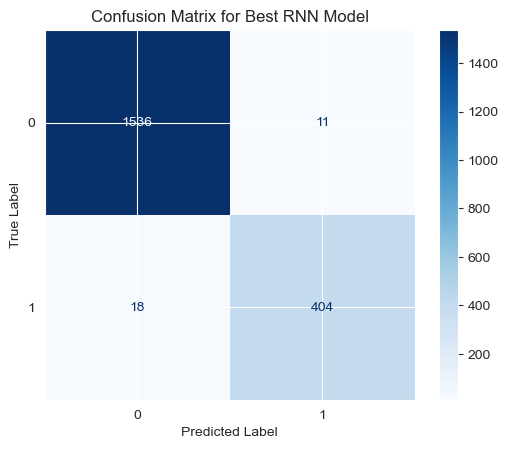

In [56]:
start_time = time.time()
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)

Training_time_RF = time.time() - start_time
print(f"Training time for RF: {Training_time_RF:.2f} seconds")
start_time = time.time()

preds_RF = RF.predict(norm_test_f)

testing_time_RF = time.time() - start_time
print(f"Training time for RF: {testing_time_RF:.2f} seconds")

cm = confusion_matrix(y_test, preds_RF)
print("Confusion Matrix:")
print(cm)

print(classification_report(y_test, preds_RF))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Best RF Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Training time for LR: 0.31 seconds
Training time for LR: 0.00 seconds
Confusion Matrix:
[[1537   10]
 [  12  410]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1547
           1       0.98      0.97      0.97       422

    accuracy                           0.99      1969
   macro avg       0.98      0.98      0.98      1969
weighted avg       0.99      0.99      0.99      1969


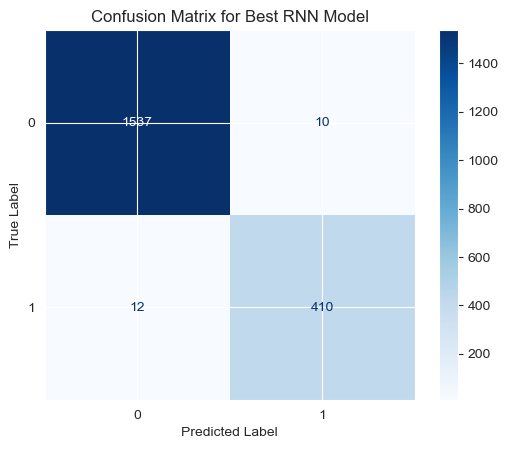

In [57]:
start_time = time.time()
xgb_c = xgb.XGBClassifier(random_state=42)
xgb_c.fit(x_tr_resample, y_tr_resample)

Training_time_XGB = time.time() - start_time
print(f"Training time for XGB: {Training_time_XGB:.2f} seconds")
start_time = time.time()

preds_xgb = xgb_c.predict(norm_test_f)


testing_time_XGB = time.time() - start_time
print(f"Training time for XGB: {testing_time_XGB:.2f} seconds")

cm = confusion_matrix(y_test, preds_xgb)
print("Confusion Matrix:")
print(cm)

print(classification_report(y_test, preds_xgb))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Best XGB Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Training time for SVM: 0.60 seconds
Training time for LR: 0.17 seconds
Confusion Matrix:
[[1546    1]
 [ 422    0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1547
           1       0.00      0.00      0.00       422

    accuracy                           0.79      1969
   macro avg       0.39      0.50      0.44      1969
weighted avg       0.62      0.79      0.69      1969


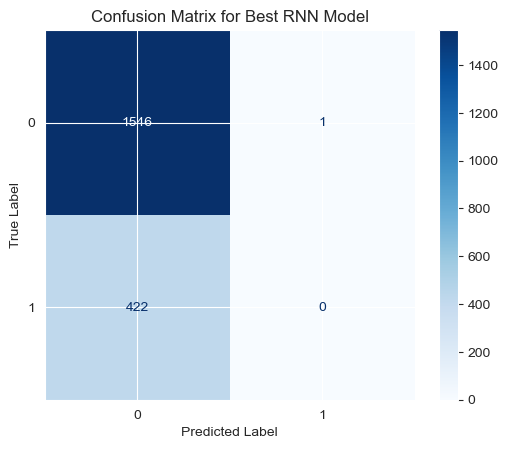

In [58]:
from sklearn import svm

start_time = time.time()
model = svm.SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train_scaled, y_train)

Training_time_SVM = time.time() - start_time
print(f"Training time for SVM: {Training_time_SVM:.2f} seconds")
start_time = time.time()

y_pred = model.predict(X_test_scaled)


testing_time_SVM = time.time() - start_time
print(f"Training time for LR: {testing_time_SVM:.2f} seconds")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Best SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

LOF model detection time: 0.19 seconds
LOF model detection time: 0.12 seconds


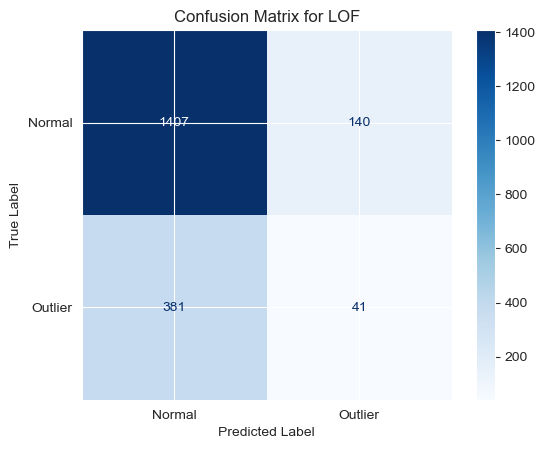


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1547
           1       0.23      0.10      0.14       422

    accuracy                           0.74      1969
   macro avg       0.51      0.50      0.49      1969
weighted avg       0.67      0.74      0.69      1969


In [61]:

start_time = time.time()
# Create a LOF model
lof = LocalOutlierFactor()
lof.fit(x_tr_resample, y_tr_resample)

train_time_LOF = time.time() - start_time
print(f"LOF model detection time: {train_time_LOF:.2f} seconds")

start_time = time.time()
outliers = lof.fit_predict(norm_test_f)

test_time_LOF = time.time() - start_time
print(f"LOF model detection time: {test_time_LOF:.2f} seconds")


# Separate normal and outlier data
normal_data = norm_test_f[outliers == 1]
outlier_data = norm_test_f[outliers == -1]


# Create a virtual label, marking known outliers as 1 and non-outliers as 0
y_true = np.zeros(len(norm_test_f))
y_true[y_test] = 0

# Predict outliers using the final LOF model
predicted_labels = np.where(outliers == 1, 0, 1)

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Compute classification report
report = classification_report(y_test, predicted_labels)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Outlier'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for LOF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:")
print(report)

Isolation Forest model detection time: 0.08 seconds
Isolation Forest model detection time: 0.05 seconds
              precision    recall  f1-score   support

          -1       0.91      0.56      0.69      1547
           1       0.33      0.79      0.46       422

    accuracy                           0.61      1969
   macro avg       0.62      0.67      0.58      1969
weighted avg       0.78      0.61      0.64      1969

Confusion Matrix:
[[863 684]
 [ 88 334]]


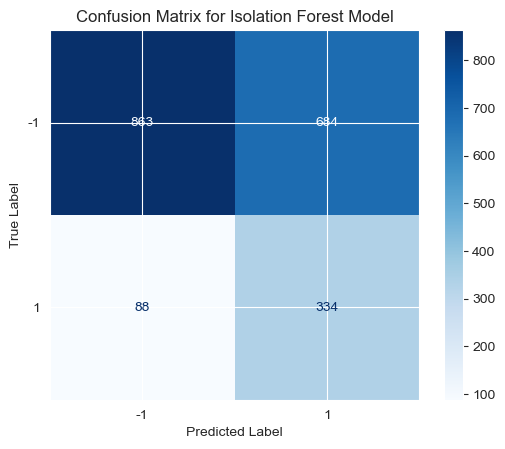

In [68]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

start_train = time.time()

# 使用 IsolationForest 进行训练
model = IsolationForest(random_state=42, bootstrap=True)
model.fit(x_tr_resample, y_tr_resample)

train_time_IF = time.time() - start_train
print(f"Isolation Forest model detection time: {train_time_IF:.2f} seconds")

test_start_time = time.time()
preds_isolation_forest = model.predict(norm_test_f)

testing_time_IF = time.time() - test_start_time
print(f"Isolation Forest model detection time: {testing_time_IF:.2f} seconds")

preds_isolation_forest = [1 if x == 1 else -1 for x in preds_isolation_forest]

y_test_binary = [1 if y == 1 else -1 for y in y_test]

print(classification_report(y_test_binary, preds_isolation_forest))
cm = confusion_matrix(y_test_binary, preds_isolation_forest)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Isolation Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


(7872, 22)
(1969, 22)
Epoch 1/15
197/197 [==============================] - 3s 5ms/step - loss: 0.5485 - accuracy: 0.7737 - val_loss: 0.5094 - val_accuracy: 0.7810
Epoch 2/15
197/197 [==============================] - 1s 3ms/step - loss: 0.5125 - accuracy: 0.7758 - val_loss: 0.4970 - val_accuracy: 0.7810
Epoch 3/15
197/197 [==============================] - 1s 3ms/step - loss: 0.4977 - accuracy: 0.7758 - val_loss: 0.4782 - val_accuracy: 0.7810
Epoch 4/15
197/197 [==============================] - 1s 3ms/step - loss: 0.4810 - accuracy: 0.7758 - val_loss: 0.4526 - val_accuracy: 0.7810
Epoch 5/15
197/197 [==============================] - 1s 3ms/step - loss: 0.4400 - accuracy: 0.7813 - val_loss: 0.3861 - val_accuracy: 0.7810
Epoch 6/15
197/197 [==============================] - 1s 3ms/step - loss: 0.3938 - accuracy: 0.8125 - val_loss: 0.3861 - val_accuracy: 0.8203
Epoch 7/15
197/197 [==============================] - 1s 3ms/step - loss: 0.3785 - accuracy: 0.8158 - val_loss: 0.3524 - val_a

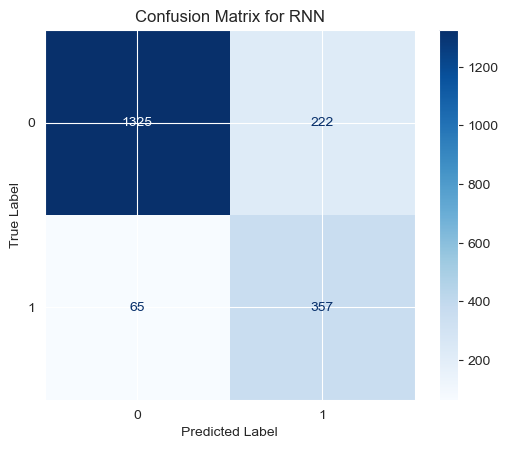

In [69]:
# 对特征进行归一化
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# 定义 RNN 模型
model = tf.keras.Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_train_time = time.time()

# 训练模型
model.fit(X_train_reshaped, y_train, epochs=15, batch_size=32, validation_split=0.2)
end_train_time = time.time()
train_time=end_train_time-start_train_time
print(f"Training time for RNN: {train_time:.2f} seconds")

# 评估模型
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

start_test_time=time.time()

# 预测测试集结果
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

end_test_time=time.time()

test_time=end_test_time-start_test_time
print(f"Testing time for RNN: {test_time:.2f} seconds")

print(classification_report(y_test, y_pred))
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 输出混淆矩阵
print("Confusion Matrix:")
print(cm)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # 根据你的标签类别修改 display_labels
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for RNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


82/82 [==============================] - 0s 1ms/step
Best Parameters: {'optimizer': 'adam'}
Best Score: 0.8445121951219513
Training time for RNN: 42.61 seconds
62/62 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1547
           1       0.80      0.08      0.14       422

    accuracy                           0.80      1969
   macro avg       0.80      0.54      0.51      1969
weighted avg       0.80      0.80      0.73      1969

Training time for RNN: 0.48 seconds
Confusion Matrix:
[[1539    8]
 [ 389   33]]


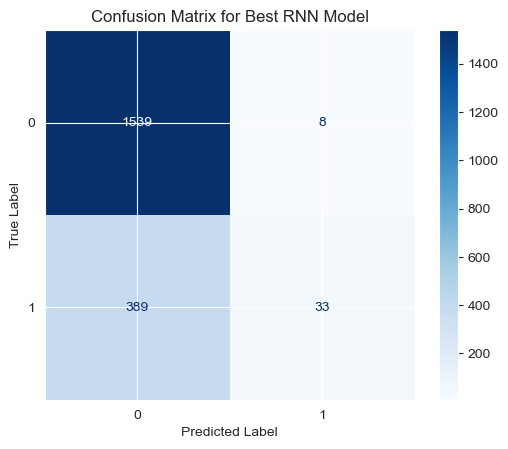

In [44]:

sarte_time = time.time()
def create_rnn_model(optimizer='adam'):
    model = tf.keras.Sequential([
        LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


rnn_model = KerasClassifier(build_fn=create_rnn_model, epochs=15, batch_size=32, verbose=0)


param_grid = {'optimizer': ['adam', 'rmsprop']}


grid_search = GridSearchCV(estimator=rnn_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_result = grid_search.fit(X_train_reshaped, y_train)


print("Best Parameters:", grid_result.best_params_)
print("Best Score:", grid_result.best_score_)
best_rnn_model = grid_result.best_estimator_
training_time_RNN = time.time() - sarte_time
print(f"Training time for RNN: {training_time_RNN:.2f} seconds")

start_time = time.time()

y_pred = best_rnn_model.predict(X_test_reshaped)
print(classification_report(y_test, y_pred))
testing_time_RNN = time.time() - start_time
print(f"Training time for RNN: {testing_time_RNN:.2f} seconds")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Best RNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


LR girded

Best Parameters: {'C': 100, 'penalty': 'l2'}
Best Cross-Validation Accuracy: 0.9433360588716271
Training time for Logistic Regression: 1.21 seconds
Testing time for Logistic Regression: 0.01 seconds
(1969,)
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1547
           1       0.81      0.94      0.87       422

    accuracy                           0.94      1969
   macro avg       0.90      0.94      0.91      1969
weighted avg       0.94      0.94      0.94      1969

[[1454   93]
 [  27  395]]


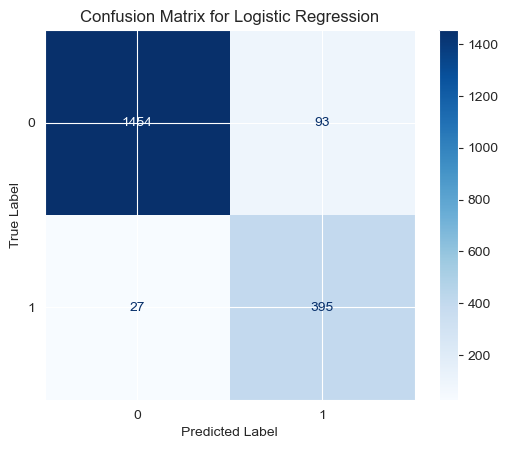

In [45]:
# 定义要调优的参数网格
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # 正则化参数
    'penalty': ['l1', 'l2']  # 正则化类型
}
train_start_time = time.time()
LR = LogisticRegression(random_state=42)
# 创建Grid Search对象
grid_search = GridSearchCV(LR, param_grid, cv=5, scoring='accuracy')

# 在训练集上拟合Grid Search对象
grid_search.fit(x_tr_resample, y_tr_resample)

# 获取最佳参数
best_LR = grid_search.best_estimator_

# 输出最佳参数组合和对应的准确率
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

train_end_time = time.time()

training_time_LR = train_end_time - train_start_time
print(f"Training time for Logistic Regression: {training_time_LR:.2f} seconds")

test_start_time = time.time()

# Transform test features

norm_test_f = norm.transform(X_test)
preds_LR = grid_search.predict(norm_test_f)
# 实例化分类器, 用fit()方法将分类器应用到SMOTE过采样后的训练集上,进行训练模型. 使用transform()方法对x_test集进行归一化处理,这样可以和训练数据集拥有相同的数值范围
# 训练好的模型对归一化的测试数据norm_test_f进行预测, 将最终的结果存储在preds变量中

# 记录测试结束时间
test_end_time = time.time()

# 计算测试时间
testing_time_LR = test_end_time - test_start_time
print(f"Testing time for Logistic Regression: {testing_time_LR:.2f} seconds")

print(y_test.shape)
y_test.value_counts()

print(classification_report(y_test, preds_LR))
print(confusion_matrix(y_test, preds_LR))
# Calculate confusion matrix
cm_LR = confusion_matrix(y_test, preds_LR)


disp_LR = ConfusionMatrixDisplay(confusion_matrix=cm_LR, display_labels=best_LR.classes_)
disp_LR.plot(cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

LOF grided

Best Parameters: {'contamination': 0.05, 'n_neighbors': 10}
Best Cross-Validation Accuracy: nan
LOF model detection time: 9.48 seconds
LOF model detection time: 0.24 seconds


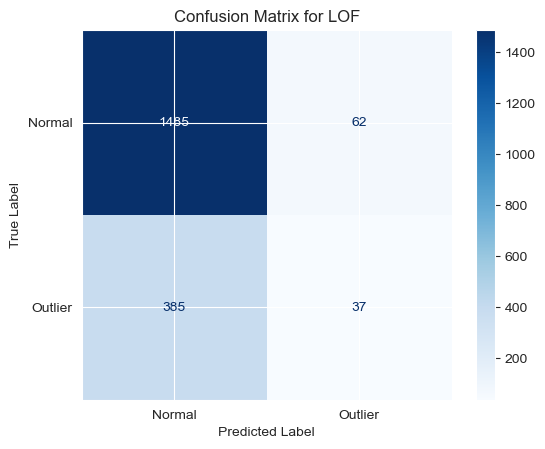


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1547
           1       0.37      0.09      0.14       422

    accuracy                           0.77      1969
   macro avg       0.58      0.52      0.51      1969
weighted avg       0.70      0.77      0.71      1969


In [46]:

# Define the parameter grid
param_grid = {
    'n_neighbors': [10, 15, 20, 25],
    'contamination': [0.05, 0.1, 0.15, 0.2]
}
start_time = time.time()
# Create a LOF model
lof = LocalOutlierFactor()

# Create a GridSearchCV object
grid_search = GridSearchCV(lof, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_tr_resample, y_tr_resample)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)
train_time_LOF = time.time() - start_time

print(f"LOF model detection time: {train_time_LOF:.2f} seconds")
test_start_time = time.time()

# Use the best parameters to create the final LOF model
best_lof = LocalOutlierFactor(**best_params)

# Fit the final model to the training data
best_lof.fit(x_tr_resample)

# Predict outliers on the test data
outliers = best_lof.fit_predict(norm_test_f)

# Calculate detection time
test_time_LOF = time.time() - test_start_time
print(f"LOF model detection time: {test_time_LOF:.2f} seconds")

# Separate normal and outlier data
normal_data = norm_test_f[outliers == 1]
outlier_data = norm_test_f[outliers == -1]


# Create a virtual label, marking known outliers as 1 and non-outliers as 0
y_true = np.zeros(len(norm_test_f))
y_true[y_test] = 0

# Predict outliers using the final LOF model
predicted_labels = np.where(outliers == 1, 0, 1)

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Compute classification report
report = classification_report(y_test, predicted_labels)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Outlier'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for LOF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:")
print(report)


Best Parameters: {'contamination': 0.05, 'max_samples': 100, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.49198691741618966
Isolation Forest model detection time: 44.64 seconds
Isolation Forest model detection time: 0.10 seconds
              precision    recall  f1-score   support

           0       0.94      0.08      0.15      1547
           1       0.23      0.98      0.37       422

    accuracy                           0.28      1969
   macro avg       0.58      0.53      0.26      1969
weighted avg       0.79      0.28      0.20      1969

[[ 128 1419]
 [   8  414]]


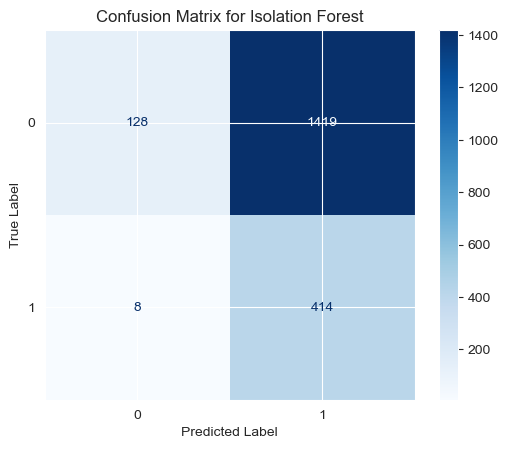

In [47]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 100, 200],
    'contamination': [0.05, 0.1, 0.15]
}
start_train=time.time()
# Create an Isolation Forest model
isolation_forest = IsolationForest(random_state=42, bootstrap=True)

# Create a GridSearchCV object
grid_search = GridSearchCV(isolation_forest, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_tr_resample, y_tr_resample)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)
train_time_IF = time.time() - start_train
print(f"Isolation Forest model detection time: {train_time_IF:.2f} seconds")
# Use the best parameters to create the final Isolation Forest model
best_isolation_forest = IsolationForest(random_state=42, bootstrap=True, **best_params)

# Fit the final model to the training data
best_isolation_forest.fit(x_tr_resample)

# Predict outliers on the test data
test_start_time = time.time()
preds_isolation_forest = best_isolation_forest.predict(norm_test_f)


# Calculate detection time
testing_time_IF = time.time() - test_start_time
print(f"Isolation Forest model detection time: {testing_time_IF:.2f} seconds")

# Convert -1 to 0 and keep 1 unchanged to match the normal/anomaly labels
preds_isolation_forest[preds_isolation_forest == -1] = 0

# Print classification report and confusion matrix
print(classification_report(y_test, preds_isolation_forest))
print(confusion_matrix(y_test, preds_isolation_forest))

# Visualize confusion matrix
cm_isolation_forest = confusion_matrix(y_test, preds_isolation_forest)
disp_isolation_forest = ConfusionMatrixDisplay(confusion_matrix=cm_isolation_forest, display_labels=[0, 1])
disp_isolation_forest.plot(cmap='Blues')
plt.title('Confusion Matrix for Isolation Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9848732624693376
SVM model training time: 78.97 seconds
SVM model detection time: 0.08 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1547
           1       0.93      0.97      0.95       422

    accuracy                           0.98      1969
   macro avg       0.96      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969

[[1517   30]
 [  13  409]]


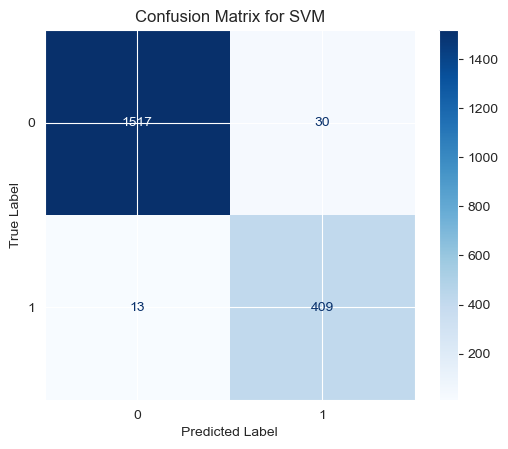

In [48]:

# 定义要搜索的参数网格
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

train_start_time = time.time()
# 创建SVM模型
SVM = SVC(random_state=42)

# 训练模型
SVM.fit(x_tr_resample, y_tr_resample)

# 创建Grid Search对象
grid_search = GridSearchCV(SVM, param_grid, cv=5, scoring='accuracy')

# 在训练集上拟合Grid Search对象
grid_search.fit(x_tr_resample, y_tr_resample)

# 输出最佳参数组合和对应的准确率
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

training_time_SVM = time.time() - train_start_time
print(f"SVM model training time: {training_time_SVM:.2f} seconds")

# 获取最佳参数的SVM模型
best_SVM = grid_search.best_estimator_

# 在测试集上进行预测
test_start_time = time.time()
preds_SVM = best_SVM.predict(norm_test_f)

# 计算检测时间
detection_time_SVM = time.time() - test_start_time
print(f"SVM model detection time: {detection_time_SVM:.2f} seconds")

# 计算混淆矩阵和分类报告
cm_SVM = confusion_matrix(y_test, preds_SVM)
print(classification_report(y_test, preds_SVM))
print(confusion_matrix(y_test, preds_SVM))

# 可视化混淆矩阵
disp_SVM = ConfusionMatrixDisplay(confusion_matrix=cm_SVM, display_labels=best_SVM.classes_)
disp_SVM.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_

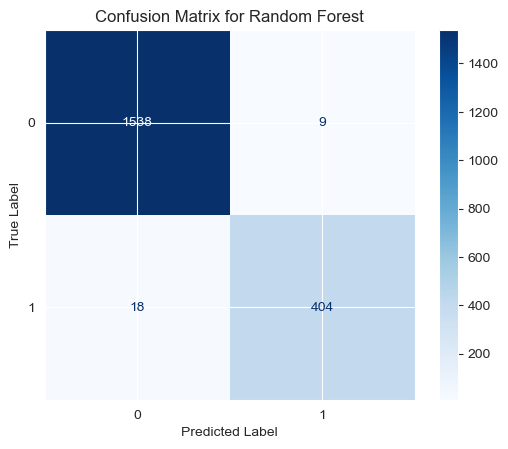

In [49]:


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

train_start_time = time.time()
# 实例化随机森林模型
RF = RandomForestClassifier(random_state=42)

# 创建Grid Search对象
grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# 在训练集上拟合Grid Search对象
grid_search.fit(x_tr_resample, y_tr_resample)

# 获取最佳参数组合
best_params = grid_search.best_params_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
# 使用最佳参数初始化随机森林模型
best_RF = RandomForestClassifier(random_state=42, **best_params)

# 训练模型

best_RF.fit(x_tr_resample, y_tr_resample)
train_end_time = time.time()
training_time_RF = train_end_time - train_start_time
print(f"RandomForest model training time: {training_time_RF:.2f} seconds")


# 在测试集上进行预测
test_start_time = time.time()
preds_RF = best_RF.predict(norm_test_f)
test_end_time = time.time()
detection_time_RF = test_end_time - test_start_time
print(f"RandomForest model detection time: {detection_time_RF:.2f} seconds")

# 计算混淆矩阵和分类报告
cm_RF = confusion_matrix(y_test, preds_RF)
print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))

# 可视化混淆矩阵
disp_RF = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=best_RF.classes_)
disp_RF.plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.3; total time=   0.0s
[CV] EN

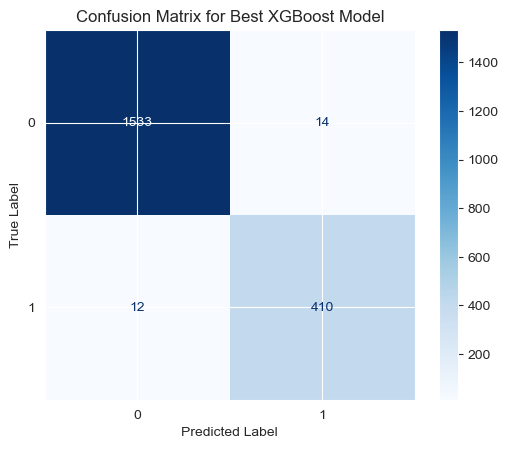

In [50]:
train_start_time = time.time()
xgb_c = xgb.XGBClassifier(random_state=42)
params_grid = {'learning_rate':[0.01, 0.1, 0.5],
              'n_estimators':[100,200],
              'subsample':[0.3, 0.5, 0.9],
               'max_depth':[2,3,4],
               'colsample_bytree':[0.3,0.5,0.7]}

best_xgb = GridSearchCV(estimator=xgb_c, param_grid=params_grid, scoring='recall', cv = 10, verbose = 2)

best_xgb.fit(x_tr_resample, y_tr_resample)
print(f'Best params found for XGBoost are: {best_xgb.best_params_}')
print(f'Best recall obtained by the best params: {best_xgb.best_score_}')
train_end_time = time.time()
training_time_XGBoost_Grid = train_end_time - train_start_time
print(f"Grid search XGBoost model training time: {training_time_XGBoost_Grid:.2f} seconds")
test_start_time = time.time()
preds_best_xgb = best_xgb.best_estimator_.predict(norm_test_f)
test_end_time = time.time()
detection_time_XGBoost= test_end_time - test_start_time
print(f"Grid search XGBoost model detection time: {detection_time_XGBoost:.2f} seconds")

print(classification_report(y_test, preds_best_xgb))
print(confusion_matrix(y_test, preds_best_xgb))
# 使用最佳模型的混淆矩阵可视化
cm_best_xgb = confusion_matrix(y_test, preds_best_xgb)
disp_best_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_best_xgb, display_labels=best_xgb.best_estimator_.classes_)
disp_best_xgb.plot(cmap='Blues')
plt.title('Confusion Matrix for Best XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Best Parameters: {'weights': [2, 2, 1]}
Best Cross-Validation Accuracy: 0.992477514309076
VotCLF model training time: 126.77 seconds
VotCLF model testing time: 0.15 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1547
           1       0.98      0.97      0.98       422

    accuracy                           0.99      1969
   macro avg       0.99      0.98      0.99      1969
weighted avg       0.99      0.99      0.99      1969

[[1540    7]
 [  11  411]]


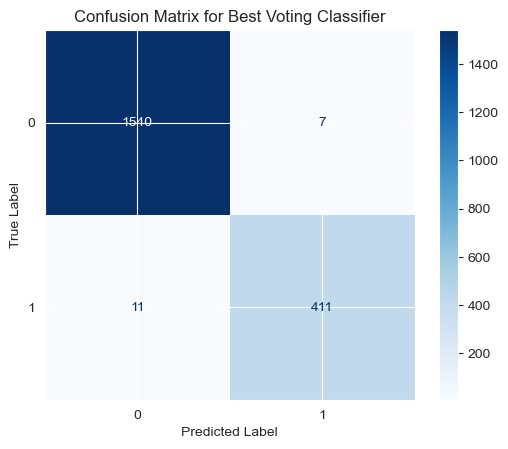

In [51]:

start_time= time.time()
best_params_xgboost = {'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
best_params_rf = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_params_svm = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

xgboost_model = XGBClassifier(**best_params_xgboost)
rf_model = RandomForestClassifier(**best_params_rf)
svm_model = SVC(**best_params_svm,probability=True)
# 创建参数网格，指定每个基础模型的权重范围

param_grid = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [2, 2, 1], [1, 2, 2], [2, 1, 2], [2, 2, 2]]
}

# 创建投票分类器
voting_clf = VotingClassifier(
    estimators=[('xgboost', xgboost_model), ('random_forest', rf_model), ('svm', svm_model)],
    voting='soft'  # 使用软投票
)

# 创建GridSearchCV对象
grid_search = GridSearchCV(voting_clf, param_grid, cv=5, scoring='accuracy')

# 在训练集上拟合Grid Search对象
grid_search.fit(x_tr_resample, y_tr_resample)

# 输出最佳参数组合和对应的准确率
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# 获取最佳参数的投票分类器模型
best_voting_clf = grid_search.best_estimator_
training_time_Voting = time.time() - start_time
print(f"VotCLF model training time: {training_time_Voting:.2f} seconds")
start_time = time.time()

# 在测试集上进行预测
preds_best_voting_clf = best_voting_clf.predict(norm_test_f)

testing_time_Voting = time.time() - start_time
print(f"VotCLF model testing time: {testing_time_Voting:.2f} seconds")

# 计算混淆矩阵和分类报告
cm_best_voting_clf = confusion_matrix(y_test, preds_best_voting_clf)
print(classification_report(y_test, preds_best_voting_clf))
print(confusion_matrix(y_test, preds_best_voting_clf))

# 可视化混淆矩阵
disp_best_voting_clf = ConfusionMatrixDisplay(confusion_matrix=cm_best_voting_clf, display_labels=best_voting_clf.classes_)
disp_best_voting_clf.plot(cmap='Blues')
plt.title('Confusion Matrix for Best Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

[I 2024-06-22 19:29:53,965] A new study created in memory with name: no-name-c8d86350-1e7b-4b5d-9e8a-c50261fe0ece
[I 2024-06-22 19:30:04,142] Trial 0 finished with value: 0.9832402234636871 and parameters: {'final_estimator': 'xgboost', 'colsample_bytree': 0.29571822345576104, 'learning_rate': 0.44155456366642903, 'max_depth': 6, 'n_estimators': 232, 'subsample': 0.6094150171247246}. Best is trial 0 with value: 0.9832402234636871.
[I 2024-06-22 19:30:14,419] Trial 1 finished with value: 0.9873031995937024 and parameters: {'final_estimator': 'rf', 'rf_max_depth': 18, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 7, 'rf_n_estimators': 96}. Best is trial 1 with value: 0.9873031995937024.
[I 2024-06-22 19:30:24,512] Trial 2 finished with value: 0.9867953275774505 and parameters: {'final_estimator': 'lr', 'lr_C': 1.741061339178192, 'lr_penalty': 'l2'}. Best is trial 1 with value: 0.9873031995937024.
[I 2024-06-22 19:30:34,518] Trial 3 finished with value: 0.9867953275774505 and paramet

Best trial:
Value:  0.9883189436262062
Params: 
    final_estimator: lr
    lr_C: 9.956505312899566
    lr_penalty: l2
Best Stacking Model:
StackingClassifier(cv=5,
                   estimators=[('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
             

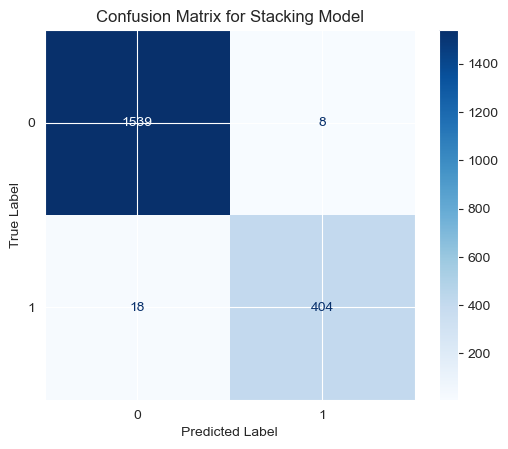

In [52]:
start_time = time.time()
best_params_xgboost = {'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
best_params_rf = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_params_svm = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
# 定义基础模型
xgboost_model = XGBClassifier(**best_params_xgboost)
rf_model = RandomForestClassifier(**best_params_rf)
svm_model = SVC(**best_params_svm)
lr = LogisticRegression(random_state=43)
rf = RandomForestClassifier(random_state=43)

# 定义final_estimator的参数搜索空间
def objective(trial):
    final_estimator = trial.suggest_categorical('final_estimator', ['xgboost', 'lr', 'rf'])
    if final_estimator == 'xgboost':
        params = {
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0)
        }
        model = XGBClassifier(**params)
    elif final_estimator == 'lr':
        lr_params = {
            'C': trial.suggest_float('lr_C', 0.1, 10.0),
            'penalty': trial.suggest_categorical('lr_penalty', ['l2'])
        }
        model = LogisticRegression(**lr_params)
    elif final_estimator == 'rf':
        rf_params = {
            'max_depth': trial.suggest_int('rf_max_depth', 1, 20),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
            'n_estimators': trial.suggest_int('rf_n_estimators', 50, 300)
        }
        model = RandomForestClassifier()
    else:
        raise ValueError("Invalid final estimator.")

    stacking_clf = StackingClassifier(
        estimators=[
            ('xgboost', xgboost_model),
            ('random_forest', rf_model),
            ('svm', svm_model)
        ],
        final_estimator=model,
        cv=5
    )

    stacking_clf.fit(X_train, y_train)
    y_pred_stacking = stacking_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_stacking)
    return accuracy


# 使用Optuna搜索最佳参数
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 输出最佳参数
# 打印最佳模型和参数

print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 使用最佳参数创建最终的StackingClassifier
final_estimator = trial.params['final_estimator']
if final_estimator == 'xgboost':
    final_params = {
        'colsample_bytree': trial.params['colsample_bytree'],
        'learning_rate': trial.params['learning_rate'],
        'max_depth': trial.params['max_depth'],
        'n_estimators': trial.params['n_estimators'],
        'subsample': trial.params['subsample']
    }
    model = XGBClassifier(**final_params)
elif final_estimator == 'lr':
    lr_params = {
        'C': trial.suggest_float('lr_C', 0.1, 10.0),
        'penalty': trial.suggest_categorical('lr_penalty', ['l2'])
    }
    model = LogisticRegression(**lr_params)
elif final_estimator == 'rf':
    rf_params = {
        'max_depth': trial.suggest_int('rf_max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
        'n_estimators': trial.suggest_int('rf_n_estimators', 50, 300)
    }
    model = RandomForestClassifier()

stacking_clf = StackingClassifier(
    estimators=[
        ('xgboost', xgboost_model),
        ('random_forest', rf_model),
        ('svm', svm_model)
    ],
    final_estimator=model,
    cv=5
)
print("Best Stacking Model:")
print(stacking_clf)

# 训练Stacking模型
stacking_clf.fit(X_train, y_train)
training_time_stacking = time.time() - start_time
print(f"stacking model testing time: {training_time_stacking:.2f} seconds")
start_time = time.time()
# 预测并评估模型
y_pred_stacking = stacking_clf.predict(X_test)
print(f"stacking model testing time: {time.time() - start_time:}")

accuracy = accuracy_score(y_test, y_pred_stacking)
print("Accuracy of Stacking Model:", accuracy)

print(classification_report(y_test, y_pred_stacking))
print(confusion_matrix(y_test, y_pred_stacking))

# 计算混淆矩阵
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
# 可视化混淆矩阵
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=stacking_clf.classes_)
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [53]:
best_params_xgboost = {'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
best_params_rf = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_params_svm = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

xgboost_model = XGBClassifier(**best_params_xgboost)
rf_model = RandomForestClassifier(**best_params_rf)
svm_model = SVC(**best_params_svm)

start_time = time.time()

# 定义三个基学习器
best_params_xgboost = {'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
best_params_rf = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_params_svm = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

xgboost_model = XGBClassifier(**best_params_xgboost)
rf_model = RandomForestClassifier(**best_params_rf)
svm_model = SVC(**best_params_svm)

# 训练 SVM 模型并增加错误实例的权重
svm_model.fit(X_train, y_train)
svm_errors = svm_model.predict(X_train) != y_train
svm_sample_weights = np.ones(len(y_train))
svm_sample_weights[svm_errors] *= 2  # 增加 SVM 模型预测错误实例的权重

# 训练 XGBoost 模型
xgboost_model.fit(X_train, y_train, sample_weight=svm_sample_weights)


# 获取 XGBoost 模型预测结果
xgboost_preds = xgboost_model.predict(X_test)

# 训练 Random Forest 模型并增加错误实例的权重
rf_model.fit(X_train, y_train)
rf_errors = rf_model.predict(X_train) != y_train
rf_sample_weights = np.ones(len(y_train))
rf_sample_weights[rf_errors] *= 2  # 增加 Random Forest 模型预测错误实例的权重

# 训练 Random Forest 模型

rf_model.fit(X_train, y_train, sample_weight=rf_sample_weights)
training_time_Boosting = time.time() - start_time

start_time=time.time()
# 获取 Random Forest 模型预测结果
rf_preds = rf_model.predict(X_test)
testing_time_boosting = time.time() - start_time
# 输出 Random Forest 模型的混淆矩阵和分类报告
print("Confusion Matrix for Boosting Model:")
print(confusion_matrix(y_test, rf_preds))
print("\nClassification Report for Boosting Model:")
print(classification_report(y_test, rf_preds))

print("Training Time of boosting:", training_time_Boosting, "seconds")
print("Testing Time of boosting", testing_time_boosting, "seconds")

# 计算混淆矩阵
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
# 可视化混淆矩阵
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=stacking_clf.classes_)
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Confusion Matrix for Boosting Model:
[[1535   12]
 [  23  399]]

Classification Report for Boosting Model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1547
           1       0.97      0.95      0.96       422

    accuracy                           0.98      1969
   macro avg       0.98      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969

Training Time of boosting: 4.067792892456055 seconds
Testing Time of boosting 0.014007329940795898 seconds


Data Visualization: Original Models

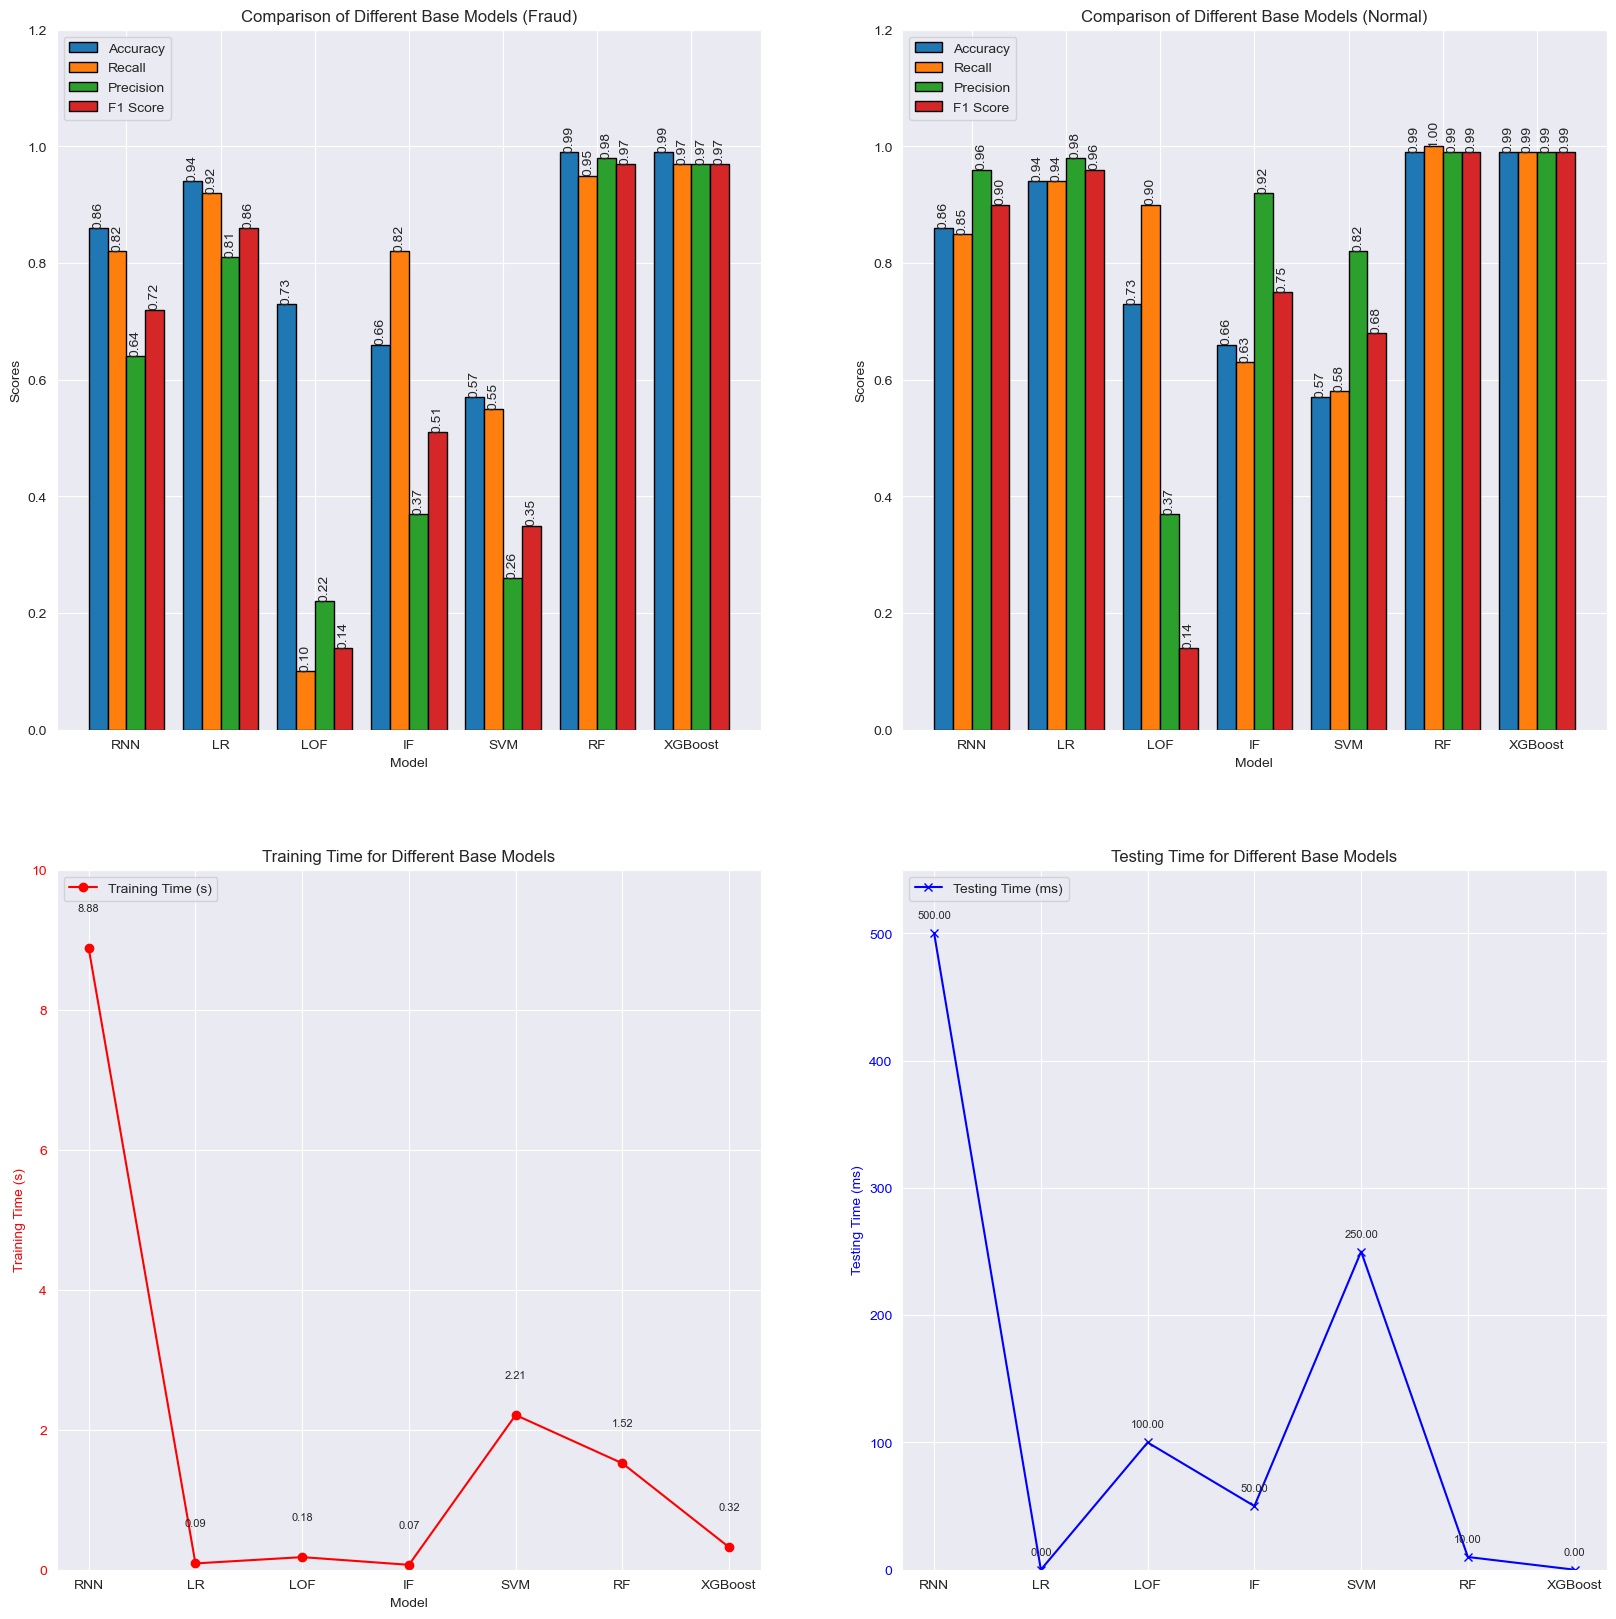

In [70]:

results_Fraud={
    "Model": ["RNN", "LR", "LOF", "IF", "SVM", "RF", "XGBoost"],
    "Accuracy": [0.86,0.94,0.73,0.66,0.57,0.99,0.99],
    "Recall":   [0.82,0.92,0.1,0.82,0.55,0.95,0.97],
    "Precision": [0.64,0.81,0.22,0.37,0.26,0.98,0.97],
    "F1 Score": [0.72,0.86,0.14,0.51,0.35,0.97,0.97],
    "Training Time (s)": [8.88,0.09,0.18,0.07,2.21,1.52,0.32],
    "Testing Time (s)": [0.5,0,0.1,0.05,0.25,0.01,0]
}
results_Normal={
    "Model": ["RNN", "LR", "LOF", "IF", "SVM", "RF", "XGBoost"],
    "Accuracy": [0.86, 0.94, 0.73, 0.66, 0.57, 0.99, 0.99],
    "Recall": [0.85,0.94,0.9,0.63,0.58,1,0.99],
    "Precision": [0.96,0.98,0.37,0.92,0.82,0.99,0.99],
    "F1 Score": [0.9,0.96,0.14,0.75,0.68,0.99,0.99],
}
results_Time={
    "Model": ["RNN", "LR", "LOF", "IF", "SVM", "RF", "XGBoost"],
    "Training Time (s)": [8.88, 0.09, 0.18, 0.07, 2.21, 1.52, 0.32],
    "Testing Time (s)": [0.5, 0, 0.1, 0.05, 0.25, 0.01, 0]
}


results_Fraud = pd.DataFrame(results_Fraud)
results_Normal = pd.DataFrame(results_Normal)
results_Time = pd.DataFrame(results_Time)



# Training Time & Testing Time 折线图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

# Add the Training Time & Testing Time line plots
# Set the bar chart parameters
n_models = len(results_Fraud)
n_metrics = 4  # Accuracy, Recall, Precision, F1 Score
bar_width = 0.2  # Bar width
index = np.arange(n_models)  # Index of each model

# Plot the bar chart for each metric, with black outlines
for i, metric in enumerate(["Accuracy", "Recall", "Precision", "F1 Score"]):
    bars = ax1.bar(index + i * bar_width, results_Fraud[metric], bar_width, label=metric, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)

ax1.set_ylim(0, 1.2)
ax1.set_xlabel('Model')
ax1.set_ylabel('Scores')
ax1.set_title('Comparison of Different Base Models (Fraud)')
ax1.set_xticks(index + bar_width * (n_metrics - 1) / 2, results_Fraud['Model'], rotation=0)
ax1.legend(loc='upper left')

# Repeat the same process for the Normal results
n_models = len(results_Normal)
index = np.arange(n_models)
for i, metric in enumerate(["Accuracy", "Recall", "Precision", "F1 Score"]):
    bars = ax2.bar(index + i * bar_width, results_Normal[metric], bar_width, label=metric, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)

ax2.set_ylim(0, 1.2)
ax2.set_xlabel('Model')
ax2.set_ylabel('Scores')
ax2.set_title('Comparison of Different Base Models (Normal)')
ax2.set_xticks(index + bar_width * (n_metrics - 1) / 2, results_Normal['Model'], rotation=0)
ax2.legend(loc='upper left')

# Plot the Training Time line plot
ax3.plot(results_Time["Model"], results_Time["Training Time (s)"], marker='o', linestyle='-', color='red', label='Training Time (s)')
for i, time in enumerate(results_Time["Training Time (s)"]):
    ax3.text(i, time + 0.5, f"{time:.2f}", ha='center', va='bottom', fontsize=8)
ax3.set_xlabel('Model')
ax3.set_ylabel('Training Time (s)', color='red')
ax3.tick_params('y', colors='red')
ax3.set_ylim(0, 10)
ax3.set_title('Training Time for Different Base Models')
ax3.legend(loc='upper left')

# Plot the Testing Time line plot
ax4.plot(results_Time["Model"], [time * 1000 for time in results_Time["Testing Time (s)"]], marker='x', linestyle='-', color='blue', label='Testing Time (ms)')
for i, time in enumerate(results_Time["Testing Time (s)"]):
    ax4.text(i, time * 1000 + 10, f"{time * 1000:.2f}", ha='center', va='bottom', fontsize=8)
ax4.set_ylabel('Testing Time (ms)', color='blue')
ax4.tick_params('y', colors='blue')
ax4.set_ylim(0, 550)
ax4.set_title('Testing Time for Different Base Models')
ax4.legend(loc='upper left')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
# plt.savefig('Original.pdf')
plt.show()

Data Visualization: Grided Models

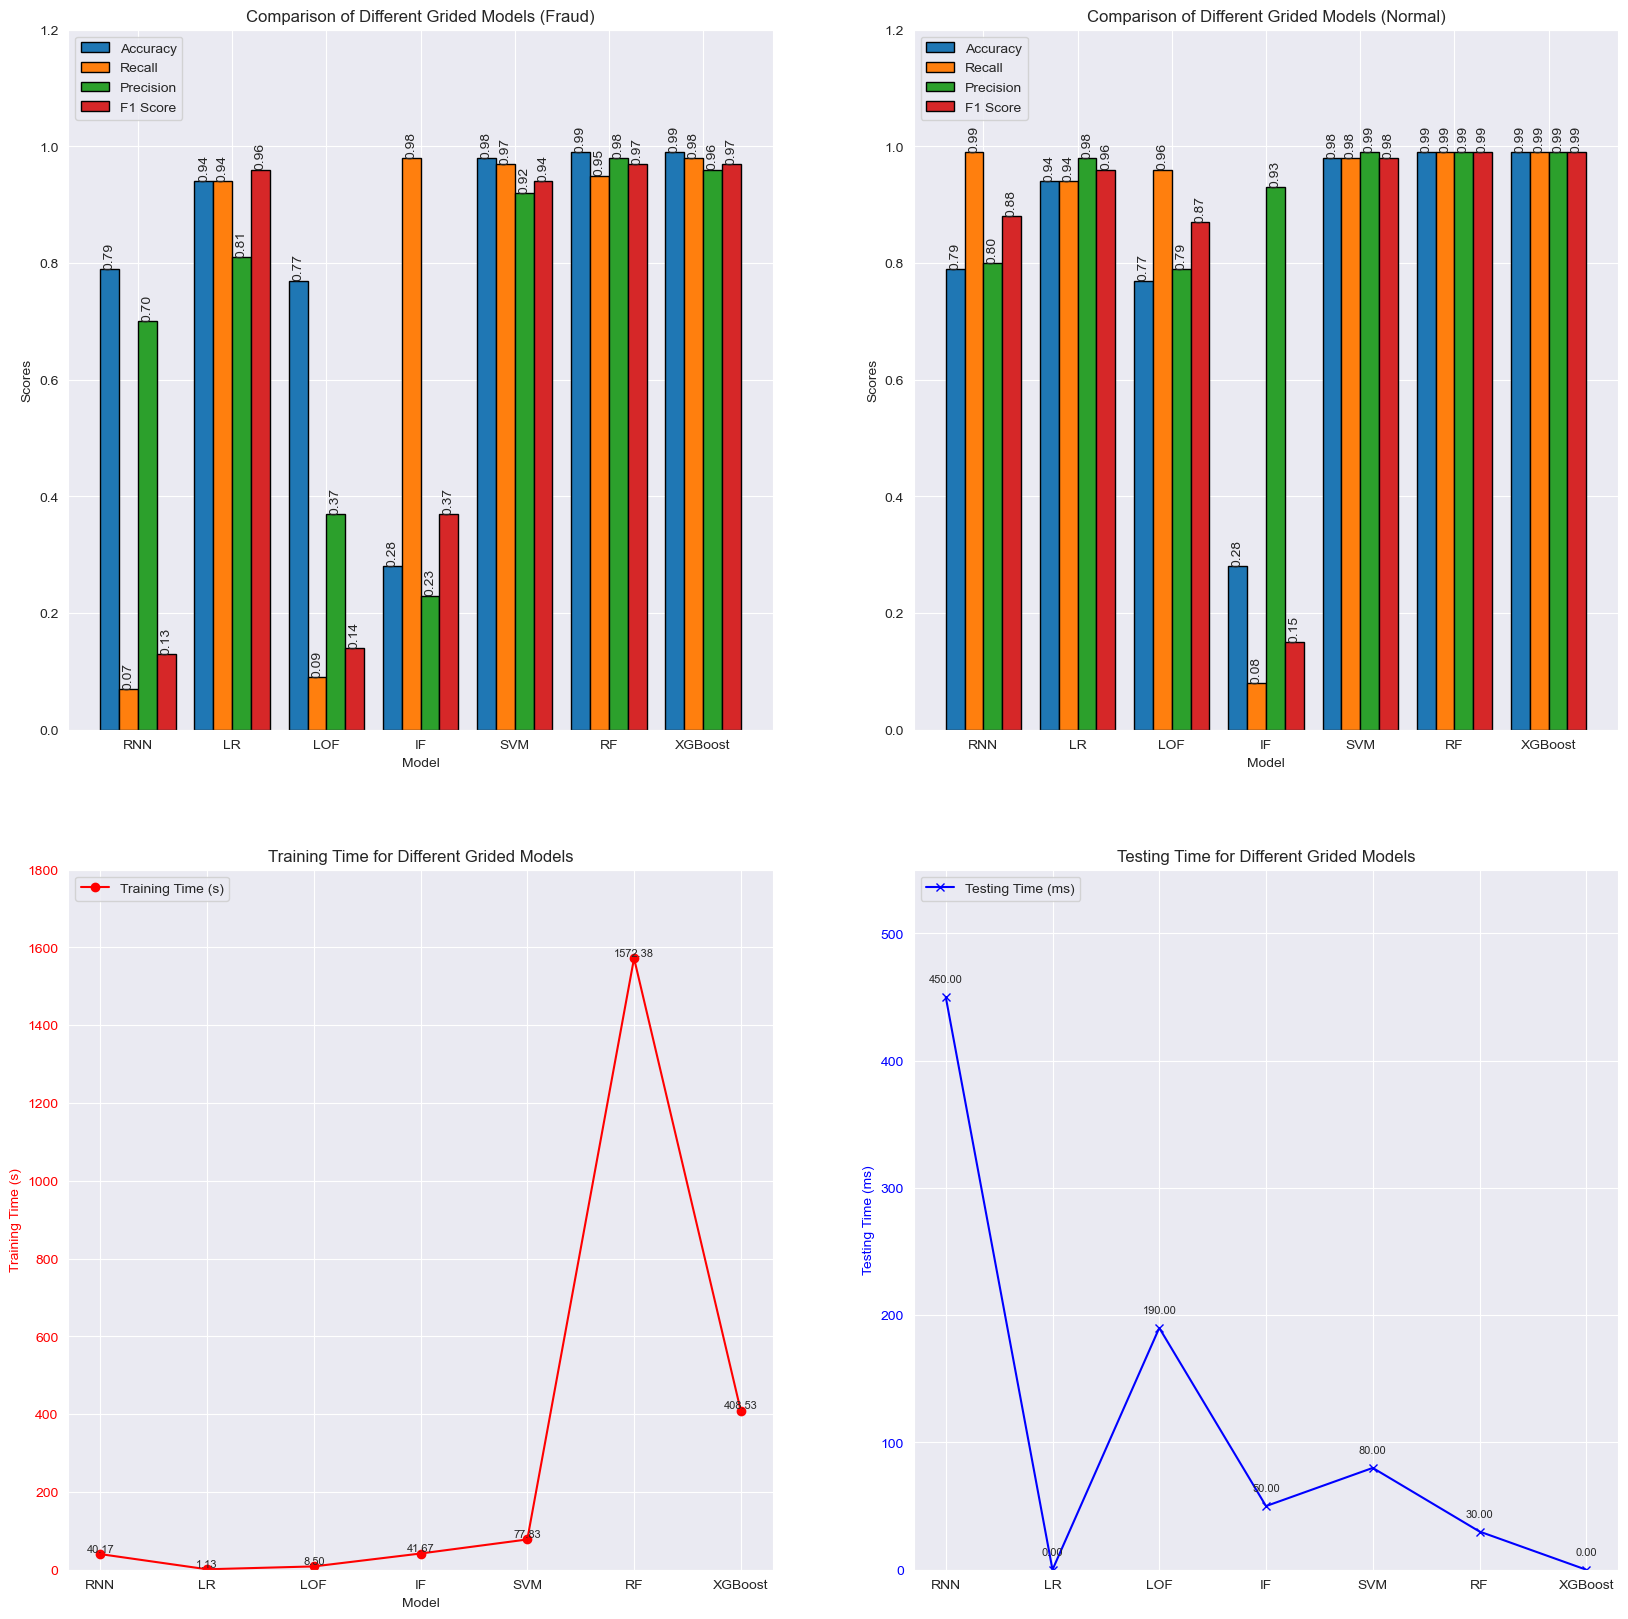

In [71]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

results_Fraud={
    "Model": ["RNN", "LR", "LOF", "IF", "SVM", "RF", "XGBoost"],
    "Accuracy": [0.79,0.94,0.77,0.28,0.98,0.99,0.99],
    "Recall":   [0.07,0.94,0.09,0.98,0.97,0.95,0.98,],
    "Precision": [0.7,0.81,0.37,0.23,0.92,0.98,0.96],
    "F1 Score": [0.13,0.96,0.14,0.37,0.94,0.97,0.97],

}
results_Normal={
    "Model": ["RNN", "LR", "LOF", "IF", "SVM", "RF", "XGBoost"],
    "Accuracy": [0.79,0.94,0.77,0.28,0.98,0.99,0.99],
    "Recall": [0.99,0.94,0.96,0.08,0.98,0.99,0.99,],
    "Precision": [0.8,0.98,0.79,0.93,0.99,0.99,0.99],
    "F1 Score": [0.88,0.96,0.87,0.15,0.98,0.99,0.99],
}
results_Time={
    "Model": ["RNN", "LR", "LOF", "IF", "SVM", "RF", "XGBoost"],
    "Training Time (s)": [40.17,1.13,8.5,41.67,77.83,1572.38,408.53],
    "Testing Time (s)": [0.45,0,0.19,0.05,0.08,0.03,0]
}


results_Fraud = pd.DataFrame(results_Fraud)
results_Normal = pd.DataFrame(results_Normal)
results_Time = pd.DataFrame(results_Time)



# Training Time & Testing Time 折线图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

# Add the Training Time & Testing Time line plots
# Set the bar chart parameters
n_models = len(results_Fraud)
n_metrics = 4  # Accuracy, Recall, Precision, F1 Score
bar_width = 0.2  # Bar width
index = np.arange(n_models)  # Index of each model

# Plot the bar chart for each metric, with black outlines
for i, metric in enumerate(["Accuracy", "Recall", "Precision", "F1 Score"]):
    bars = ax1.bar(index + i * bar_width, results_Fraud[metric], bar_width, label=metric, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)

ax1.set_ylim(0, 1.2)
ax1.set_xlabel('Model')
ax1.set_ylabel('Scores')
ax1.set_title('Comparison of Different Grided Models (Fraud)')
ax1.set_xticks(index + bar_width * (n_metrics - 1) / 2, results_Fraud['Model'], rotation=0)
ax1.legend(loc='upper left')

# Repeat the same process for the Normal results
n_models = len(results_Normal)
index = np.arange(n_models)
for i, metric in enumerate(["Accuracy", "Recall", "Precision", "F1 Score"]):
    bars = ax2.bar(index + i * bar_width, results_Normal[metric], bar_width, label=metric, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)

ax2.set_ylim(0, 1.2)
ax2.set_xlabel('Model')
ax2.set_ylabel('Scores')
ax2.set_title('Comparison of Different Grided Models (Normal)')
ax2.set_xticks(index + bar_width * (n_metrics - 1) / 2, results_Normal['Model'], rotation=0)
ax2.legend(loc='upper left')

# Plot the Training Time line plot
ax3.plot(results_Time["Model"], results_Time["Training Time (s)"], marker='o', linestyle='-', color='red', label='Training Time (s)')
for i, time in enumerate(results_Time["Training Time (s)"]):
    ax3.text(i, time + 0.5, f"{time:.2f}", ha='center', va='bottom', fontsize=8)
ax3.set_xlabel('Model')
ax3.set_ylabel('Training Time (s)', color='red')
ax3.tick_params('y', colors='red')
ax3.set_ylim(0, 1800)
ax3.set_title('Training Time for Different Grided Models')
ax3.legend(loc='upper left')

# Plot the Testing Time line plot
ax4.plot(results_Time["Model"], [time * 1000 for time in results_Time["Testing Time (s)"]], marker='x', linestyle='-', color='blue', label='Testing Time (ms)')
for i, time in enumerate(results_Time["Testing Time (s)"]):
    ax4.text(i, time * 1000 + 10, f"{time * 1000:.2f}", ha='center', va='bottom', fontsize=8)
ax4.set_ylabel('Testing Time (ms)', color='blue')
ax4.tick_params('y', colors='blue')
ax4.set_ylim(0, 550)
ax4.set_title('Testing Time for Different Grided Models')
ax4.legend(loc='upper left')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Grided.pdf')
plt.show()

Data Visualization: Ensemble Models

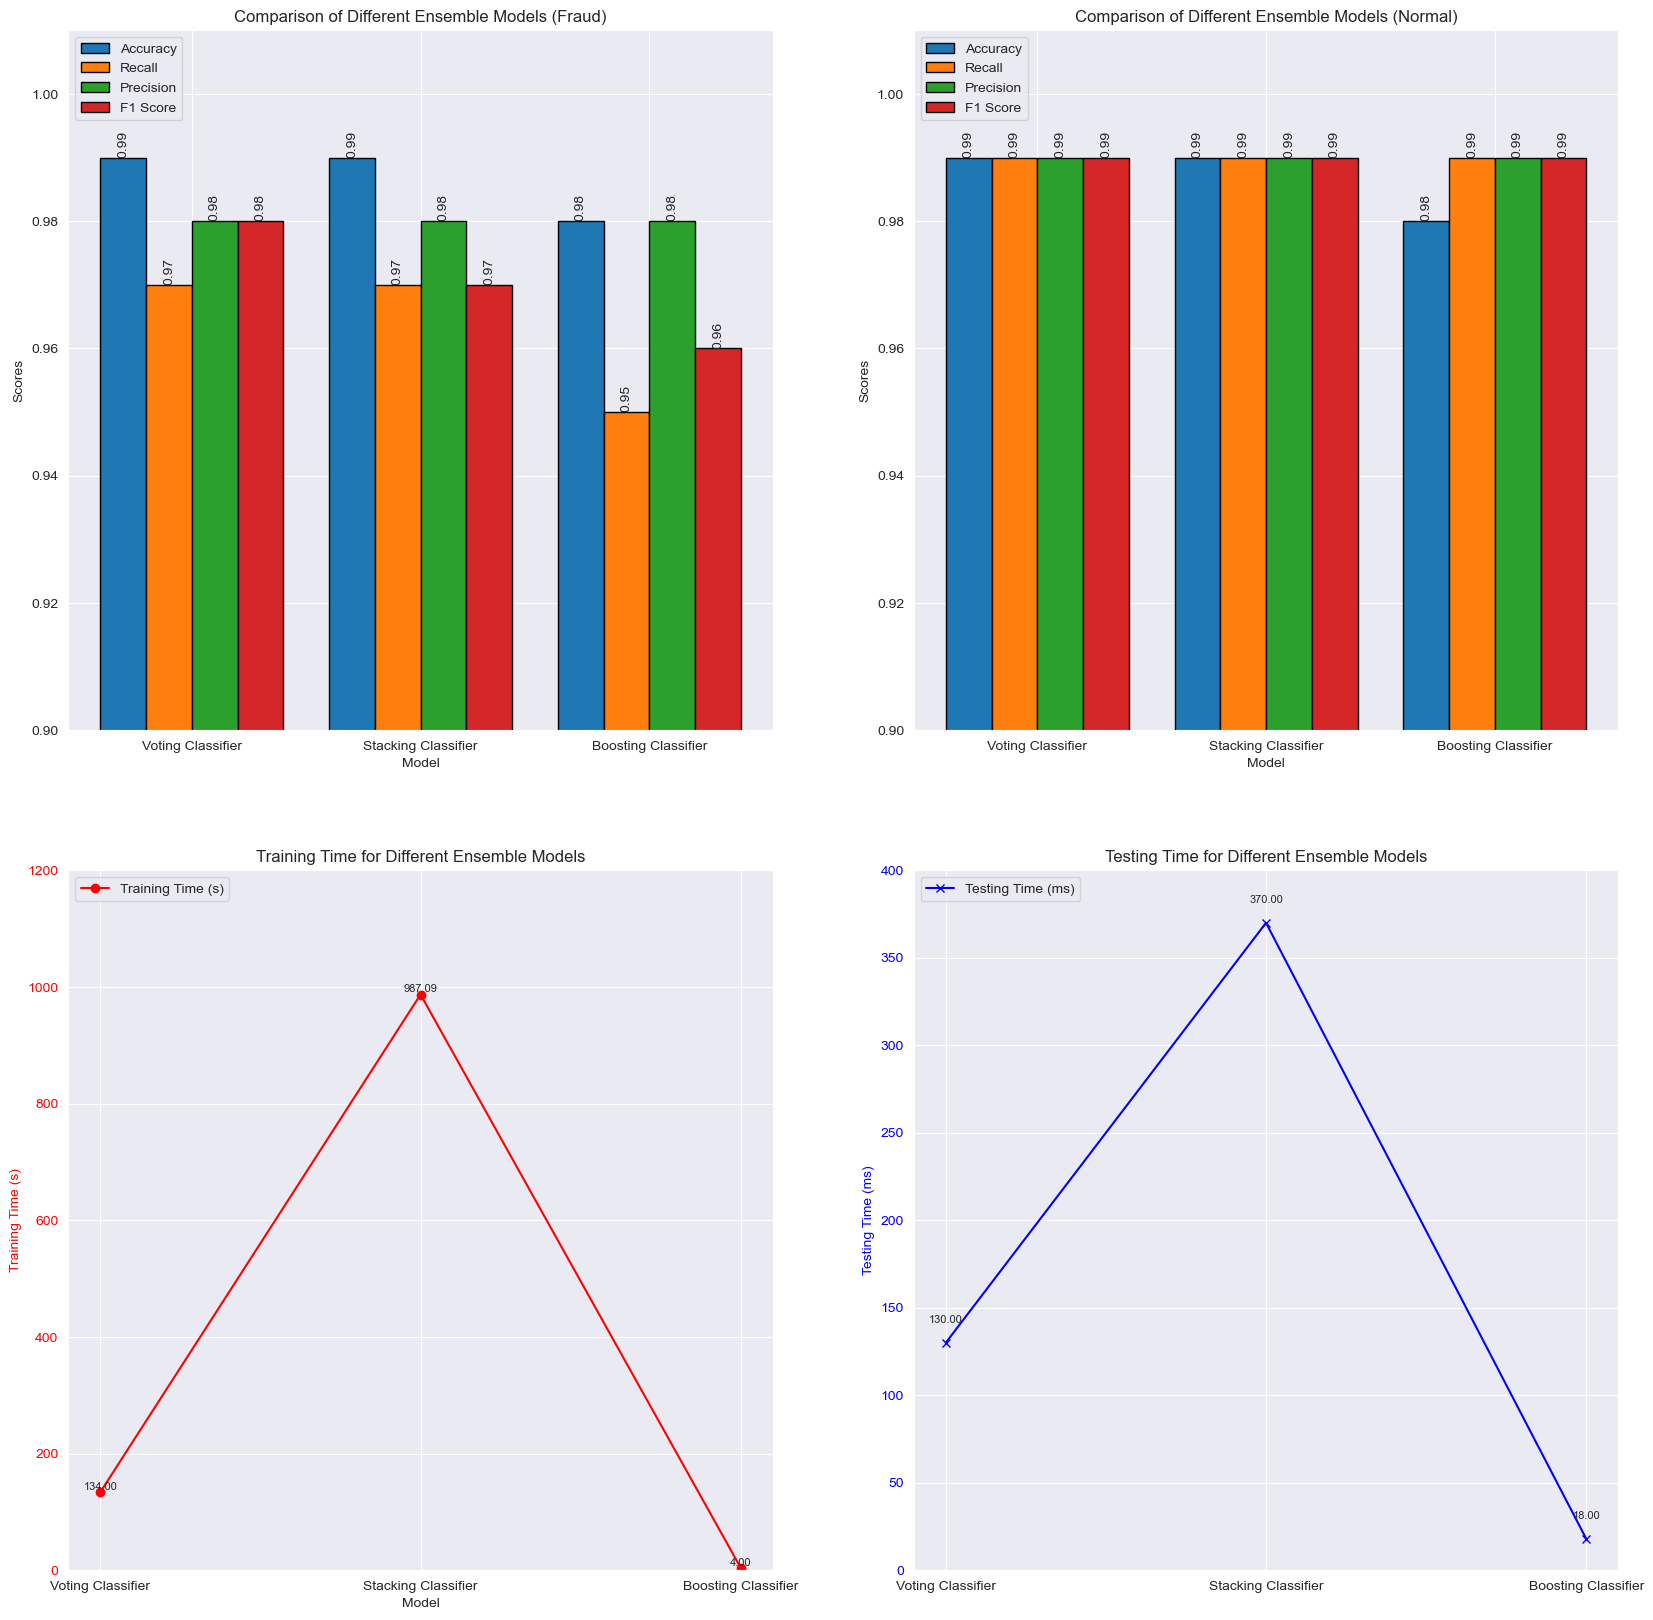

In [73]:
results_Fraud={
    "Model": ["Voting Classifier", "Stacking Classifier", "Boosting Classifier"],
    "Accuracy": [0.99,0.99, 0.98],
    "Recall":   [0.97,0.97,0.95],
    "Precision": [0.98,0.98,0.98],
    "F1 Score": [0.98,0.97,0.96],
    "Training Time (s)": [134,987.09,3.999],
    "Testing Time (s)": [0.13,0.37,0.018]
}
results_Normal={
    "Model": ["Voting Classifier", "Stacking Classifier", "Boosting Classifier"],
    "Accuracy": [0.99,0.99, 0.98],
    "Recall": [0.99,0.99, 0.99],
    "Precision": [0.99,0.99, 0.99],
    "F1 Score":[0.99,0.99, 0.99],
}
results_Time={
    "Model": ["Voting Classifier", "Stacking Classifier", "Boosting Classifier"],
    "Training Time (s)": [134,987.09,3.999],
    "Testing Time (s)": [0.13,0.37,0.018]
}

results_Fraud = pd.DataFrame(results_Fraud)
results_Normal = pd.DataFrame(results_Normal)
results_Time = pd.DataFrame(results_Time)


# Training Time & Testing Time 折线图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,20))

# Add the Training Time & Testing Time line plots
# Set the bar chart parameters
n_models = len(results_Fraud)
n_metrics = 4  # Accuracy, Recall, Precision, F1 Score
bar_width = 0.2  # Bar width
index = np.arange(n_models)  # Index of each model

# Plot the bar chart for each metric, with black outlines
for i, metric in enumerate(["Accuracy", "Recall", "Precision", "F1 Score"]):
    bars = ax1.bar(index + i * bar_width, results_Fraud[metric], bar_width, label=metric, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)

ax1.set_ylim(0.9, 1.01)
ax1.set_xlabel('Model')
ax1.set_ylabel('Scores')
ax1.set_title('Comparison of Different Ensemble Models (Fraud)')
ax1.set_xticks(index + bar_width * (n_metrics - 1) / 2, results_Fraud['Model'], rotation=0)
ax1.legend(loc='upper left')

# Repeat the same process for the Normal results
n_models = len(results_Normal)
index = np.arange(n_models)
for i, metric in enumerate(["Accuracy", "Recall", "Precision", "F1 Score"]):
    bars = ax2.bar(index + i * bar_width, results_Normal[metric], bar_width, label=metric, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)

ax2.set_ylim(0.9, 1.01)
ax2.set_xlabel('Model')
ax2.set_ylabel('Scores')
ax2.set_title('Comparison of Different Ensemble Models (Normal)')
ax2.set_xticks(index + bar_width * (n_metrics - 1) / 2, results_Normal['Model'], rotation=0)
ax2.legend(loc='upper left')

# Plot the Training Time line plot
ax3.plot(results_Time["Model"], results_Time["Training Time (s)"], marker='o', linestyle='-', color='red', label='Training Time (s)')
for i, time in enumerate(results_Time["Training Time (s)"]):
    ax3.text(i, time + 0.5, f"{time:.2f}", ha='center', va='bottom', fontsize=8)
ax3.set_xlabel('Model')
ax3.set_ylabel('Training Time (s)', color='red')
ax3.tick_params('y', colors='red')
ax3.set_ylim(0, 1200)
ax3.set_title('Training Time for Different Ensemble Models')
ax3.legend(loc='upper left')

# Plot the Testing Time line plot
ax4.plot(results_Time["Model"], [time * 1000 for time in results_Time["Testing Time (s)"]], marker='x', linestyle='-', color='blue', label='Testing Time (ms)')
for i, time in enumerate(results_Time["Testing Time (s)"]):
    ax4.text(i, time * 1000 + 10, f"{time * 1000:.2f}", ha='center', va='bottom', fontsize=8)
ax4.set_ylabel('Testing Time (ms)', color='blue')
ax4.tick_params('y', colors='blue')
ax4.set_ylim(0, 400)
ax4.set_title('Testing Time for Different Ensemble Models')
ax4.legend(loc='upper left')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Ensamble.pdf')
plt.show()